# **Simulating a LCDM (Lambda Cold Dark-Matter) Universe**

## **LCDM Implementation Improvements**

For our previous lcdm_sim notebooks, we used physical time $t$, fixed $Δt$ as the integration variable for our sim evolution. This time, we will instead use the scaling factor $a$, fixed $Δa$ as the integration varibale. Why?
  - integrating in $a$ naturally adapts the physical time step, as our $Δt \approx Δa /(aH(a))$
  - this is more stable and efficient for cosmo simulations.
  - recall, we originally set our $Δt$ to be 0.1, and we set a defined number of timesteps, but even after running for 100+ timesteps, the simulation did not evolve that much. This is due to us using a very small value for the timesteps relative to the overall age of the universe, and it will take a very long time to get the simulation to evolve.

We will also use efficient libs/packages like Numba and PyFFTW for significant simulation speedups, instead of the standard Numpy/scipy we originally used.

In [ ]:
!pip install numba pyfftw
import numba      # Used for our functions that have explicit loops/ heavy operations.
import pyfftw     # Used for faster computation of FFT.
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.6 MB/s eta 0:00:00


In [ ]:
# Configuring of threads Numba/Pyfftw can use.
try:
  n_cpu = len(os.sched_getaffinity(0))
except AttributeError:
  import multiprocessing
  n_cpu = multiprocessing.cpu_count()       # Fallback
print(f"Using {n_cpu} CPUs for threads.")
num_threads = n_cpu

Using 8 CPUs for threads.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Use astropy units for clarity in conversions
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fft import fftn, ifftn, fftfreq # Use scipy's fft instead of numpy's version.

RANDOM_SEED = 43

# Integration parameters using scale factor 'a':
a_initial = 0.01                          # Initial scale factor (a_initial)
a_final = 1.0                             # Final scale factor
num_steps = 1000                          # Number of integration steps in 'a'
da = (a_final - a_initial) / num_steps    # Step size in scale factor 'a' (delta_a)

# Grid parameters:
N_particles_1d = 128                      # Particles per dimension N_p = N_particles_1d**3
N_grid_1d = 128                           # Grid cells per dimension N_g = N_grid_1d**3
L = 100                                   # Box size [Mpc/h].
k0 = 2 * np.pi / L                        # Fundamental wavenumber [h/Mpc].
ns = 0.96                                 # Spectral index.
A = 2.1e-9                                # Amplitude normalization (Planck 2018 scalar amplitude As)
sigma8_val = 0.811                        # Target sigma_8 value for normalization (Planck 2018)

# Cosmological parameters:
H0_val = 67.66
Om0 = 0.3097
Ob0 = 0.0484
Ok0 = 0.00
Ode0 = 0.6847
Tcmb0 = 2.7255
cosmo = FlatLambdaCDM(H0=H0_val, Om0=Om0, Ob0=Ob0, Tcmb0=Tcmb0)

h = cosmo.h                               # H0/100.
z_initial = 1.0 / a_initial - 1           # Redshift at initial scaling factor.
a = a_initial                             # Starting scaling factor.

In [ ]:
# Growth rate f(z) approximation function:
def growth_rate_approx(z, cosmo_obj, gamma=0.55):
  return cosmo_obj.Om(z)**gamma

# Growth factor D(z) numerical function:
def growth_factor_numerical(a, cosmo_obj):
  def growth_ode(y, a):
    D, D_prime = y
    z = 1.0 / a - 1.0

    # Need H(a) and H'(a) = dH/da
    H_a = cosmo.H(z).to(u.km / u.s / u.Mpc).value
    E_a = H_a / cosmo.H0.value

    # Calculate dE/da = (dE/dz) * (dz/da)
    # dz/da = -1/a^2
    # Need dE/dz. E^2 = Om0*(1+z)^3 + Ok0*(1+z)^2 + Ode0
    # differentiating E^2 wrt to z:
    # 2*E*(dE/dz) = 3*Om0*(1+z)^2 + 2*Ok0*(1+z)
    # dE/dz = (3*Om0*(1+z)**2 + 2*cosmo_obj.Ok0*(1+z)) / (2 * E_a) # Ok0 is 0 here
    dE_dz = (3.0 * cosmo_obj.Om0 * (1.0 + z)**2) / (2.0 * E_a)
    dE_da = dE_dz * (-1.0 / a**2)

    # H'(a) = H0 * dE/da
    H_prime_a = cosmo_obj.H0.value * dE_da

    # Calculate Omega_m(a)
    Om_a = cosmo_obj.Om(z)

    # The ODE: D'' + (3/a + H'/H)D' - (3/2a^2)*Om(a)*D = 0
    # D'' = - (3/a + H'/H)D' + (3/2a^2)*Om(a)*D
    term1_coeff = (3.0 / a) + (H_prime_a / H_a)
    term2_coeff = (1.5 / a**2) * Om_a

    D_double_prime = -term1_coeff * D_prime + term2_coeff * D
    return [D_prime, D_double_prime]

  # Integration range setup (we will start deep in the matter-dominated era).
  a_start_ode = 1e-5
  a_end_ode = 1.0
  n_steps_ode = 500
  a_span = np.logspace(np.log10(a_start_ode), np.log10(a_end_ode), n_steps_ode)

  # Initial conditions: in deep matter-dominated territory, D ~ a, so D=a, D'=1
  y0 = [a_start_ode, 1.0]

  # Solving the full ODE using scipy's odeint function.
  solution = odeint(growth_ode, y0, a_span)

  # Getting the D(a) values from the solution and normalizing it using the D(a) value
  # closest to a=1.
  D_unnorm = solution[:, 0]             # unnormalized D(a) for each step.
  D_at_a_is_1 = D_unnorm[-1]
  D_norm = D_unnorm / D_at_a_is_1

  # Now, we need to build an interpolation function. We will get the normalized
  # D(a) for each corresponding scaling factor a in a_span, so that we can extract
  # any D(a) value given any a, so long as a in within the a_span range.
  growth_factor_interp = interp1d(a_span, D_norm, kind='cubic', fill_value="extrapolate")
  return growth_factor_interp(a)

# Calculate initial growth factor D(a_initial) and growth rate f(a_initial)
D_initial = growth_factor_numerical(a_initial, cosmo)
f_initial = growth_rate_approx(z_initial, cosmo)
H_initial = cosmo.H(z_initial).to(u.km / u.s / u.Mpc).value
H0_check = cosmo.H0.to(u.km / u.s / u.Mpc).value
omega_m_check = cosmo.Om0
print(f"Numerical Growth factor D(a={a_initial:.4f}) = {D_initial:.6f}")
print(f"Approximate Growth rate f(a={a_initial:.4f}) = {f_initial:.6f}")

Numerical Growth factor D(a=0.0100) = 0.013482
Approximate Growth rate f(a=0.0100) = 0.984143


In [ ]:
print(f"Using GitHub parameters with N_particles={N_particles_1d}, N_grid_cells={N_grid_1d}, L={L} Mpc/h")
print(f"Cosmology: H0={H0_check:.2f} km/s/Mpc, Om0={omega_m_check:.3f}, Ob0={cosmo.Ob0:.3f}, h={h:.3f}")
print(f"Starting at: z={z_initial:.1f}, a={a:.4f}")
print(f"Initial Hubble parameter H(z={z_initial:.1f}): {H_initial:.2f} km/s/Mpc")
print(f"Initial linear growth factor D(z={z_initial:.1f}) (numerical): {D_initial:.4f}")
print(f"Initial growth rate f(z={z_initial:.1f}) (approx): {f_initial:.4f}")
print(f"Fundamental wavenumber k0: {k0:.4f} h/Mpc")
print(f"Target sigma8 (used for normalization): {sigma8_val}")
print(f"Spectral index ns: {ns:.2f}")

Using GitHub parameters with N_particles=128, N_grid_cells=128, L=100 Mpc/h
Cosmology: H0=67.66 km/s/Mpc, Om0=0.310, Ob0=0.048, h=0.677
Starting at: z=99.0, a=0.0100
Initial Hubble parameter H(z=99.0): 38204.38 km/s/Mpc
Initial linear growth factor D(z=99.0) (numerical): 0.0135
Initial growth rate f(z=99.0) (approx): 0.9841
Fundamental wavenumber k0: 0.0628 h/Mpc
Target sigma8 (used for normalization): 0.811
Spectral index ns: 0.96


In [ ]:
def einsenstein_hu(k, omega_m, omega_b, h):
  # k should be in h/Mpc
  k_phys = k # EH transfer function is often defined with k in h/Mpc
  # k_phys = k * h # If definition requires 1/Mpc

  omega_b_h2 = omega_b * h**2
  omega_m_h2 = omega_m * h**2
  # Need T_CMB in K
  theta_cmb = cosmo.Tcmb0.value / 2.7 # Tcmb0 is already in K

  # Eq26 Eisenstein & Hu 1998
  s = 44.5 * np.log(9.83 / omega_m_h2) / np.sqrt(1.0 + 10.0 * omega_b_h2**0.75) * h # Mpc
  # Eq31
  alpha_gamma = (1.0 - 0.328 * np.log(431.0 * omega_m_h2) * omega_b / omega_m +
                  0.38 * np.log(22.3 * omega_m_h2) * (omega_b / omega_m)**2)
  # Eq30
  gamma_eff = omega_m * h * (alpha_gamma + (1.0 - alpha_gamma) / (1.0 + (0.43 * k_phys * s)**4))
  # Eq28
  q = k_phys * theta_cmb**2 / gamma_eff # q has units of h/Mpc

  # Eq29
  L0 = np.log(np.e + 1.84 * gamma_eff * alpha_gamma * q) # Check factors, was 1.8*q in GH code
  C0 = 14.4 + 325.0 / (1.0 + 60.5 * q**1.11) # Check factors, was 14.2+731/(1+62.5q)

  # Eq27. Ensure handling of q=0
  T_tilde = np.ones_like(q)
  non_zero_q = q > 1e-10
  T_tilde[non_zero_q] = L0[non_zero_q] / (L0[non_zero_q] + C0[non_zero_q] * q[non_zero_q]**2)

  return T_tilde

In [ ]:
def power_spectrum(k, A, ns, transfer):
  T_k = transfer(k)
  # P(k) = A * k^ns * T(k)^2 (Note the T(k)^2 convention)
  Pk = np.zeros_like(k)
  non_zero_k = k > 0
  # Use k in h/Mpc for the k^ns part, for all k > 0.
  Pk[non_zero_k] = A * (k[non_zero_k] ** ns) * (T_k[non_zero_k] ** 2)
  return Pk

def fourier_space(N, L):
  k0 = 2 * np.pi / L
  np.random.seed(RANDOM_SEED) # Use the specified seed
  #k_coords = fftfreq(N) * N * k0 # k in h/Mpc
  k_coords = np.fft.fftfreq(N) * N * k0 # k in h/Mpc
  kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
  k2 = kx**2 + ky**2 + kz**2
  k = np.sqrt(k2) # Magnitude of k vector in h/Mpc.
  return kx, ky, kz, k, k2

def grf_setup(N, variance, D):
  # Complex Gaussian noise: real and imaginary parts ~ N(0, sqrt(P(k)/2))
  field_k = (np.random.normal(0, 1, (N, N, N)) +
          1j * np.random.normal(0, 1, (N, N, N))) * np.sqrt(np.abs(variance) / 2)

  # Ensure Hermitian symmetry for real output (field_k[-k] = conj(field_k[k]))
  inv_indices = np.array(np.indices((N, N, N)))
  neg_indices = -inv_indices % N
  field_k[tuple(neg_indices)] = np.conj(field_k[tuple(inv_indices)])

  field_k[0, 0, 0] = 0 # Explicitly set DC component to zero
  # Field at this point represents unscaled fluctuations at z=0.
  # Scaling it by D(z_initial) so that field represents unscaled fluctuations z_initial.
  field_k *= D
  return field_k

kx, ky, kz, k, k2 = fourier_space(N_grid_1d, L)
transfer = lambda k: einsenstein_hu(k, cosmo.Om0, cosmo.Ob0, h)
variance = power_spectrum(k, A, ns, transfer)
field_k = grf_setup(N_grid_1d, variance, D_initial)
field_real = np.fft.ifftn(field_k)
initial_density_field = np.real(field_real)

# Normalizing initial density field to get density contrast by scaling it by our
# target_std/current_std so that its variance is not too small and its correctly scaled
# to match the current amplitude.
current_std = np.std(initial_density_field)
print(f"Current std of density field: {current_std}")

target_std = sigma8_val * D_initial # target std at z_initial. std(z) = std(z=0) * D(z)
initial_density_field *= target_std / current_std
print(f"New std of density field: {np.std(initial_density_field)}")  # Should be ~0.0101...

Current std of density field: 2.4186415495577725e-13
New std of density field: 0.010933798150173353


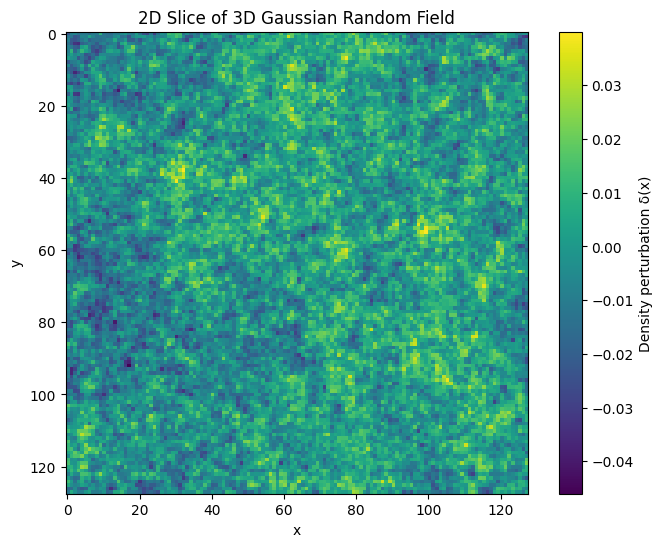

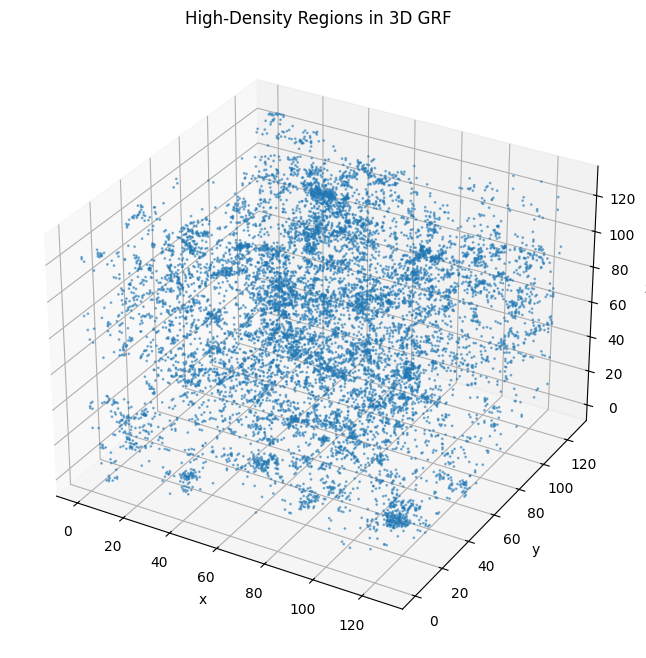

Mean density: 5.505714157152952e-20
Standard deviation: 0.010933798150173353
Min density: -5.673e-02, Max density: 5.333e-02


In [ ]:
# Visualization of the density field, a 2D slice.
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N_grid_1d//2, :, :], cmap='viridis')
plt.colorbar(label='Density perturbation δ(x)')
plt.title('2D Slice of 3D Gaussian Random Field')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Also, a 3D scatter plot of the high density regions.
threshold = np.percentile(initial_density_field, 99.5)  # Top 1% density
high_density = np.where(initial_density_field > threshold)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(high_density[0], high_density[1], high_density[2], s=1, alpha=0.5)
ax.set_title('High-Density Regions in 3D GRF')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Finally, lets print some stats.
print(f"Mean density: {np.mean(initial_density_field)}")
print(f"Standard deviation: {np.std(initial_density_field)}")
print(f"Min density: {np.min(initial_density_field):.3e}, Max density: {np.max(initial_density_field):.3e}")

In [ ]:
def zeldovich_displacement_field(density_k, N_grid, L_box):
    """Calculates the displacement field vector Psi (Mpc/h) from delta_k."""
    # density_k might be in real space, needs to be back in k/fourier space.
    density_k = np.fft.fftn(density_k)
    kx, ky, kz, k, k2 = fourier_space(N_grid, L_box)
    # Potential_k = - delta_k / k^2  (Ignoring constants for displacement)
    potential_k = np.zeros_like(density_k, dtype=complex)
    potential_k[k2 > 0] = -density_k[k2 > 0] / k2[k2 > 0]
    potential_k[0, 0, 0] = 0 # Set DC potential to zero

    displacements_k = np.zeros((3,) + density_k.shape, dtype=complex)
    # Psi_k = -i * k * Phi_k = -i * k * (-delta_k / k^2) = i * k * delta_k / k^2
    k_vec = [kx, ky, kz]
    for i in range(3):
      displacements_k[i][k2 > 0] = (1j * k_vec[i][k2 > 0] * density_k[k2 > 0]) / k2[k2 > 0]
      displacements_k[i][0, 0, 0] = 0

    displacements = np.zeros((3,) + density_k.shape)
    for i in range(3):
      displacements[i] = np.real(np.fft.ifftn(displacements_k[i]))

    return displacements # Units: Mpc/h (if delta is dimensionless)

def get_initial_conditions(N_part_1d, N_grid_1d, L_box):
    """ Sets initial particle positions and velocities using Zel'dovich."""
    # Ensure density_k is calculated if not passed
    # initial_density_field was computed globally above
    displacements = zeldovich_displacement_field(initial_density_field, N_grid_1d, L_box)

    # Initial Lagrangian positions (uniform grid)
    q_1d = np.linspace(0, L_box, N_part_1d, endpoint=False)
    qx, qy, qz = np.meshgrid(q_1d, q_1d, q_1d, indexing='ij')
    initial_lagrangian_pos = np.stack([qx, qy, qz], axis=-1).reshape(-1, 3)

    # Interpolate displacements from grid to particle positions
    # If N_part_1d == N_grid_1d, just reshape
    if N_part_1d == N_grid_1d:
      disp_at_q = displacements.transpose(1, 2, 3, 0).reshape(-1, 3) # Shape (N_p, 3)
    else:
      # Need interpolation
      grid_points = np.linspace(0, L_box, N_grid_1d, endpoint=False) # Should match density field grid
      interp_func_x = RegularGridInterpolator((grid_points, grid_points, grid_points), displacements[0], bounds_error=False, fill_value=None)
      interp_func_y = RegularGridInterpolator((grid_points, grid_points, grid_points), displacements[1], bounds_error=False, fill_value=None)
      interp_func_z = RegularGridInterpolator((grid_points, grid_points, grid_points), displacements[2], bounds_error=False, fill_value=None)

      # Interpolate at initial Lagrangian positions q
      dx = interp_func_x(initial_lagrangian_pos)
      dy = interp_func_y(initial_lagrangian_pos)
      dz = interp_func_z(initial_lagrangian_pos)
      disp_at_q = np.stack([dx, dy, dz], axis=-1)

    # Apply periodic boundary conditions to displacements if interpolating near edge
    # RegularGridInterpolator handles this if mode='wrap' is supported or grid points match L

    # Zel'dovich Positions: x(a) = q + D(a) * Psi(q)
    # Positions are comoving [Mpc/h]
    positions = initial_lagrangian_pos + disp_at_q # Note: disp_at_q already scaled by D(a_initial) via density_k
    positions %= L_box # Enforce periodic boundaries

    # Zel'dovich Velocities: v_pec(a) = a * H(a) * f(a) * D(a) * Psi(q)
    # v_pec = a * H(a) * f(a) * displacement(a)
    H_initial = cosmo.H(z_initial).to(u.km / u.s / u.Mpc).value # km/s/Mpc
    # Need f(a_initial) and displacement(a_initial) = disp_at_q
    f_init = growth_rate_approx(z_initial, cosmo)

    # Calculate peculiar velocity [km/s]
    velocities = a_initial * H_initial * f_init * disp_at_q * (1.0/h) # disp is Mpc/h, H is km/s/Mpc. Factor (1/h) makes disp -> Mpc. Result km/s.
    # velocities = a_initial * H_initial * f_init * disp_at_q # If H is km/s/(Mpc/h)

    print(f"Max initial displacement: {np.max(np.abs(disp_at_q)):.3f} Mpc/h")
    print(f"Mean initial displacement: {np.mean(np.abs(disp_at_q)):.3f} Mpc/h")
    print(f"Max initial velocity: {np.max(np.sqrt(np.sum(velocities**2, axis=1))):.1f} km/s")
    print(f"Mean initial velocity: {np.mean(np.sqrt(np.sum(velocities**2, axis=1))):.1f} km/s")

    return positions, velocities, initial_lagrangian_pos

positions, velocities, initial_lagrangian_pos = get_initial_conditions(N_particles_1d, N_grid_1d, L)
print(f"Positions shape: {positions.shape}") # Should be (N_particles_1d**3, 3)
print(f"Velocities shape: {velocities.shape}") # Should be (N_particles_1d**3, 3)

Max initial displacement: 0.088 Mpc/h
Mean initial displacement: 0.017 Mpc/h
Max initial velocity: 50.9 km/s
Mean initial velocity: 18.6 km/s
Positions shape: (2097152, 3)
Velocities shape: (2097152, 3)


Displacement stats: max=0.08824272374848063, mean=0.01668114986855065


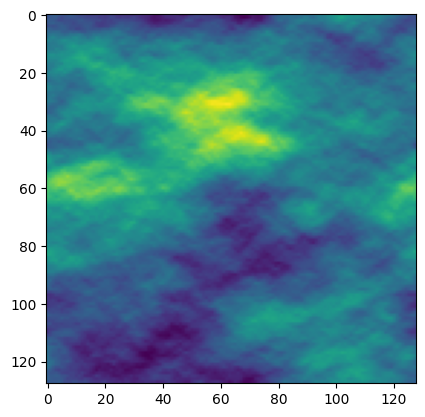

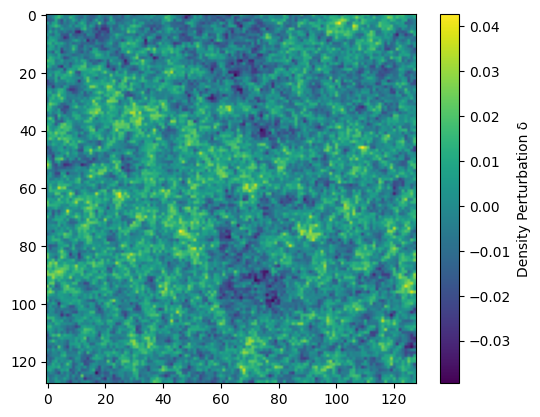

Max initial displacement: 0.088 Mpc/h
Mean initial displacement: 0.017 Mpc/h
Max initial velocity: 50.9 km/s
Mean initial velocity: 18.6 km/s
Displacement effect stats: max=99.99999833615541, mean=0.5587306230332157


In [ ]:
displacements = zeldovich_displacement_field(initial_density_field, N_grid_1d, L)
print(f"Displacement stats: max={np.max(np.abs(displacements))}, mean={np.mean(np.abs(displacements))}")
plt.imshow(displacements[0, :, :, 64], cmap='viridis')
plt.show()

plt.imshow(initial_density_field[:, :, 64], cmap='viridis')
plt.colorbar(label='Density Perturbation δ')
plt.show()

positions, velocities, initial_lagrangian_pos = get_initial_conditions(N_particles_1d, N_grid_1d, L)
displacement_effect = positions - initial_lagrangian_pos
print(f"Displacement effect stats: max={np.max(np.abs(displacement_effect))}, mean={np.mean(np.abs(displacement_effect))}")

Number of particles in slice: 114688
Plotting 20000 points for the 2D slice scatter plot.


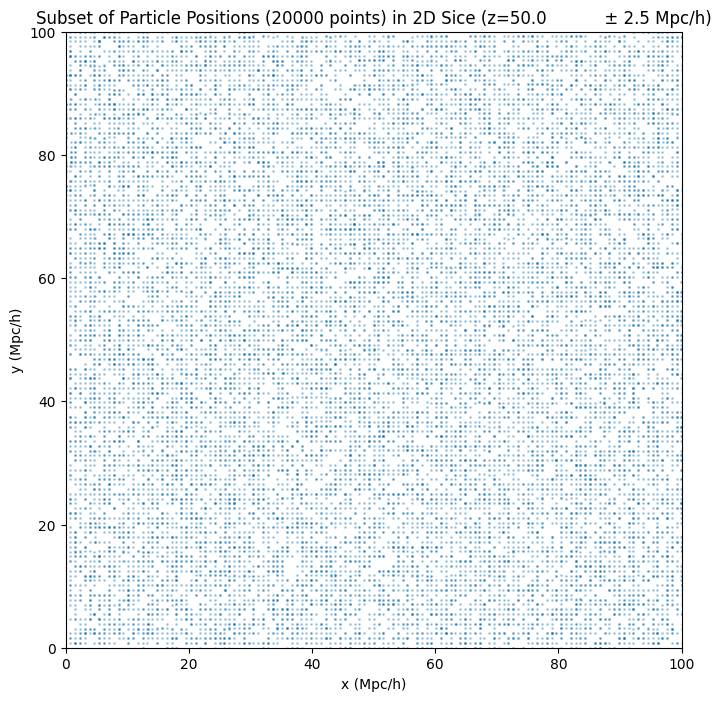

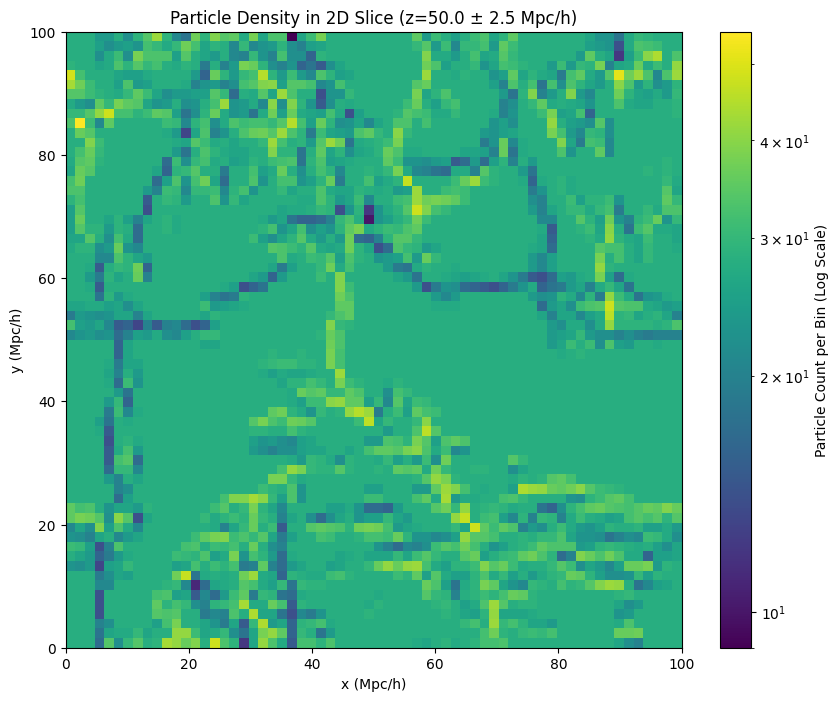

Plotting 20000 points for the overlay plot.


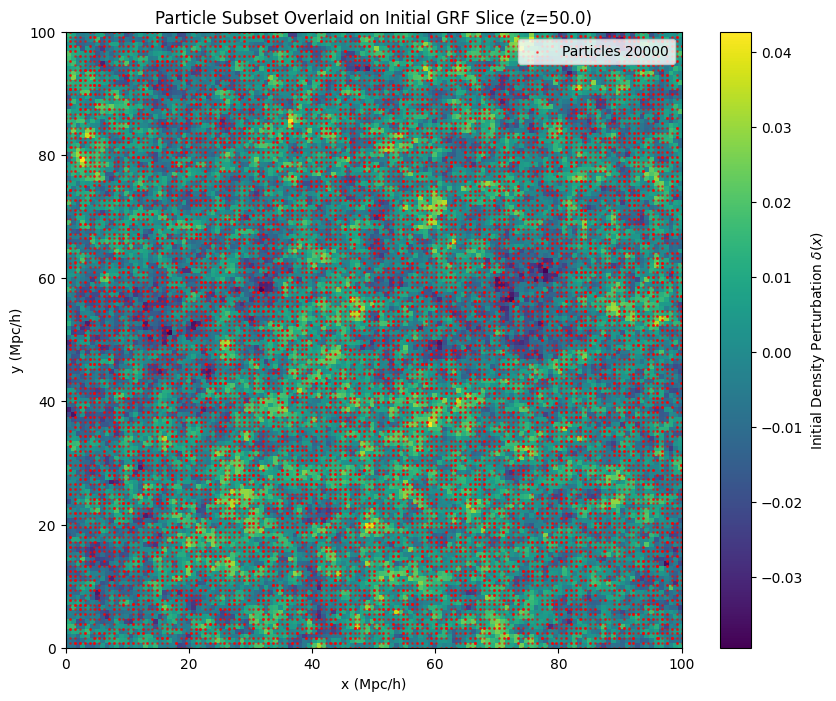

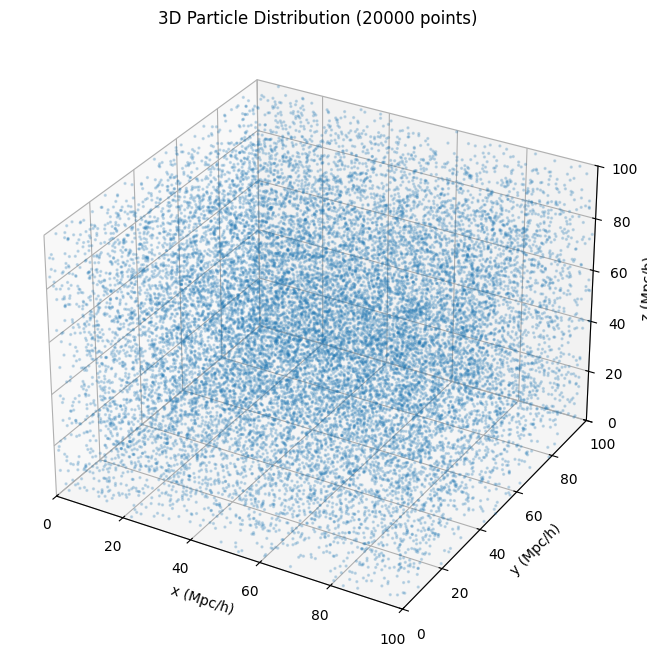

Scale factor a = 0.0100
Growth factor D = 0.0135
Hubble parameter H(a) = 38204.38 km/s/Mpc (proper)
Grid spacing h = 0.781 Mpc/h
Max displacement as fraction of h: 1.171e-01


In [ ]:
# 2D slice of the particles along one dimension, z-axis
# --- Improved 2D Slice Visualization ---

# Define slice parameters
slice_center_z = L / 2.0  # Center of the box
slice_thickness = L / 20.0 # Adjust thickness as needed (e.g., 5% of box)
z_min = slice_center_z - slice_thickness / 2.0
z_max = slice_center_z + slice_thickness / 2.0

# Select particles within the z-slice
in_slice = (positions[:, 2] >= z_min) & (positions[:, 2] < z_max)
positions_slice = positions[in_slice]

print(f"Number of particles in slice: {len(positions_slice)}") # Check how many points.

n_slice_scatter_points = 20000
if n_slice_scatter_points > len(positions_slice):
  n_slice_scatter_points = len(positions_slice)

# Randomly choosing indices from the particles already in the slice.
subset_indices_scatter = np.random.choice(len(positions_slice), n_slice_scatter_points, replace=False)
positions_slice_subset = positions_slice[subset_indices_scatter]

print(f"Plotting {n_slice_scatter_points} points for the 2D slice scatter plot.")

plt.figure(figsize=(10, 8))

# Plotting only the subset of particles.
plt.scatter(positions_slice_subset[:, 0], positions_slice_subset[:, 1], s=1, alpha=0.3) # Increase alpha
plt.title(f"Subset of Particle Positions ({n_slice_scatter_points} points) in 2D Sice (z={slice_center_z:.1f} \
          ± {slice_thickness/2.0:.1f} Mpc/h)")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.xlim(0, L)
plt.ylim(0, L)
plt.gca().set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
plt.show()

# 2D Heatmap of the density perturbations.
from matplotlib.colors import LogNorm # Import LogNorm

plt.figure(figsize=(10, 8))
# Adjust bins as needed, maybe N/4 or N/2?
nbins = N_particles_1d // 2
plt.hist2d(positions_slice[:, 0], positions_slice[:, 1],
           bins=nbins,           # Number of bins in each dimension
           range=[[0, L], [0, L]], # Explicitly set range
           cmap='viridis',        # Or 'inferno', 'magma'
           norm=LogNorm())      # Use LogNorm to see high and low densities! Essential.

plt.colorbar(label='Particle Count per Bin (Log Scale)')
plt.title(f"Particle Density in 2D Slice (z={slice_center_z:.1f} ± {slice_thickness/2.0:.1f} Mpc/h)")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Overlay slice on the GRF slice. Will compare positions directly on the initial density field
# --- Overlay Particle Slice on GRF Slice ---

# First, get the corresponding slice from the initial density field
# Ensure 'initial_density_field' is the real-space delta field computed BEFORE Zeldovich
# If you have field_k, compute: initial_density_field = np.real(np.fft.ifftn(field_k))
# NOTE: Ensure field_k used here was correctly normalized and scaled by D(z_start)

slice_index_z = int(N_particles_1d * (slice_center_z / L)) # Find grid index for slice center
grf_slice = initial_density_field[:, :, slice_index_z] # Assuming shape (Nx, Ny, Nz) - adjust if needed!

# Plotting only subset of particles from the slice.
n_overlay_points = 20000
if n_overlay_points > len(positions_slice):
  n_overlay_points = len(positions_slice)

# Randomly choosing indices from the particles already in the slice,
subset_indices_overlay = np.random.choice(len(positions_slice), n_overlay_points, replace=False)
positions_overlay_subset = positions_slice[subset_indices_overlay]

print(f"Plotting {n_overlay_points} points for the overlay plot.")

plt.figure(figsize=(10, 8))

# Plot the GRF slice first
plt.imshow(grf_slice.T, # Transpose if necessary depending on meshgrid/imshow conventions
           cmap='viridis', # Or another diverging map like 'coolwarm'
           origin='lower',
           extent=[0, L, 0, L],
           aspect='equal')
plt.colorbar(label='Initial Density Perturbation $\delta(x)$')

# Overlay the subset of particles.
plt.scatter(positions_overlay_subset[:, 0], positions_overlay_subset[:, 1],
            s=1,              # Can adjust for smaller point size.
            alpha=0.5,
            c='red',
            label=f'Particles {n_overlay_points}') # Updating label.

plt.title(f"Particle Subset Overlaid on Initial GRF Slice (z={slice_center_z:.1f})")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.xlim(0, L)
plt.ylim(0, L)
plt.legend()
plt.show()

# Plotting a 3D scatter of a subset of particles.
# --- Improved 3D Scatter Plot ---

# Increase the number of points in the subset
n_subset_3d = 20000 # Try 10k, 20k, 50k - depends on performance
if n_subset_3d > len(positions):
    n_subset_3d = len(positions) # Don't request more than available

subset_indices = np.random.choice(len(positions), n_subset_3d, replace=False)
positions_subset_3d = positions[subset_indices]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Adjust size and alpha if needed
ax.scatter(positions_subset_3d[:, 0], positions_subset_3d[:, 1], positions_subset_3d[:, 2],
           s=2, alpha=0.2) # Smaller points, maybe lower alpha if dense
ax.set_title(f"3D Particle Distribution ({n_subset_3d} points)")
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
# Set limits to box size for context
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)
plt.show()


print(f"Scale factor a = {a:.4f}")
print(f"Growth factor D = {D_initial:.4f}")
print(f"Hubble parameter H(a) = {H_initial:.2f} km/s/Mpc (proper)")

# Compare to grid spacing.
h = L / N_grid_1d
print(f"Grid spacing h = {h:.3f} Mpc/h")
print(f"Max displacement as fraction of h: {np.max(np.sqrt(np.sum(displacements**2, axis=0))) / h:.3e}")

In [ ]:
@numba.njit    # Lets not do parallelization for now, simple/direct addition might not be thread safe w/ parallel=True.
def cic_density(positions, N, L):
  # Simulation's grid spacing initialization, followed by wrapping of the positions
  # to handle periodic boundary conditions.
  N_part_total = positions.shape[0]
  h = L / N
  wrapped_pos = positions % L
  density_grid = np.zeros((N, N, N), dtype=np.float64)

  # Usage of integer floor function on particle coords to get the patent cell indices.
  # Computation of normalized distances and subsequent weights for each dimension.
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h
  xc, yc, zc = xp.astype(np.int64), yp.astype(np.int64), zp.astype(np.int64)
  dx, dy, dz = xp-xc, yp-yc, zp-zc
  tx, ty, tz = 1-dx, 1-dy, 1-dz

  # Usage of weights for each dimension for computation of the weights for the 8 neighboring
  # grid points. These represents the contributions of each weight to their respective points.
  w000 = tx * ty * tz
  w100 = dx * ty * tz
  w010 = tx * dy * tz
  w001 = tx * ty * dz
  w110 = dx * dy * tz
  w011 = tx * dy * dz
  w101 = dx * ty * dz
  w111 = dx * dy * dz

  # Initialization of new density grid, as well as grid's indicies using our parent cell indices.
  # Making sure we take into account periodicity.
  # Explict loop for the assignment for easier optimization for Numba.
  for p in range(N_part_total):
    i0, i1 = xc[p] % N, (xc[p]+1) % N # Indexing with p
    j0, j1 = yc[p] % N, (yc[p]+1) % N # Indexing with p
    k0, k1 = zc[p] % N, (zc[p]+1) % N # Indexing with p

    # Particle mass assignment to the its 8 respective neighboring grid points.
    # As of now, lets keep particle's mass to be 1.
    mp = 1
    density_grid[i0, j0, k0] += mp * w000[p] # Indexing with p and using +=
    density_grid[i1, j0, k0] += mp * w100[p] # Indexing with p and using +=
    density_grid[i0, j1, k0] += mp * w010[p] # Indexing with p and using +=
    density_grid[i0, j0, k1] += mp * w001[p] # Indexing with p and using +=
    density_grid[i1, j1, k0] += mp * w110[p] # Indexing with p and using +=
    density_grid[i0, j1, k1] += mp * w011[p] # Indexing with p and using +=
    density_grid[i1, j0, k1] += mp * w101[p] # Indexing with p and using +=
    density_grid[i1, j1, k1] += mp * w111[p] # Indexing with p and using +=

  # The result is our density grid where each point's value is the total mass
  # assigned to it, based on the weight's contribution at that specific grid point.
  # Remember, the weight is determined by the distance of the particle from that point.

  mean_mass_per_cell = N_part_total * mp / (N**3)
  if mean_mass_per_cell > 0:
    delta_grid = density_grid / mean_mass_per_cell - 1
  else:
    delta_grid = np.zeros_like(density_grid)

  # Sanity check
  #print(f"CIC Mean density (mass per cell): {np.mean(density_grid):.3f} (Expected: {mean_mass_per_cell:.3f})")
  #print(f"CIC Mean delta: {np.mean(delta_grid):.3e} (Should be ~0)")
  #print(f"CIC Total mass assigned: {np.sum(density_grid):.1f} (Should equal N_part = {N_part_total})")

  return delta_grid

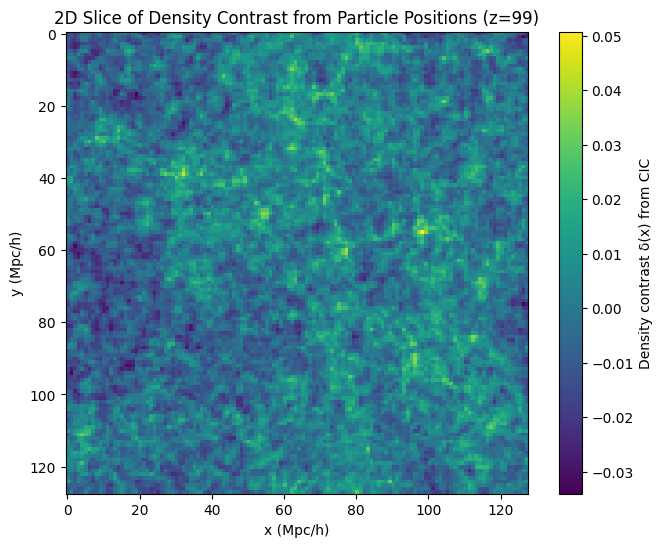

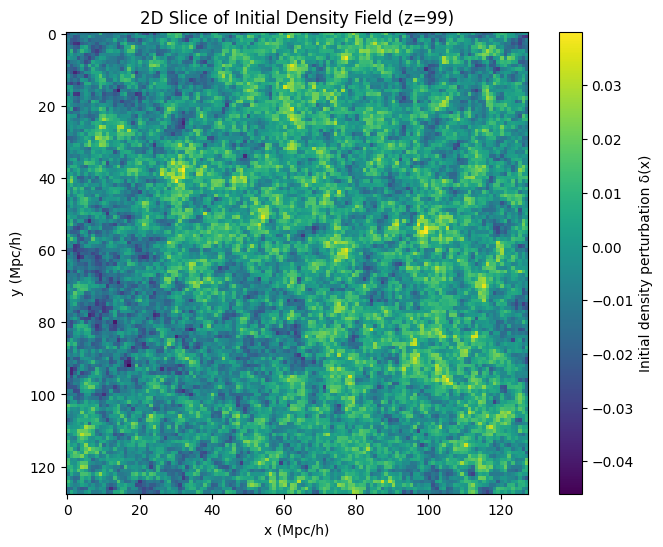

Standard deviation of initial δ: 1.093e-02
Standard deviation of CIC δ: 9.484e-03


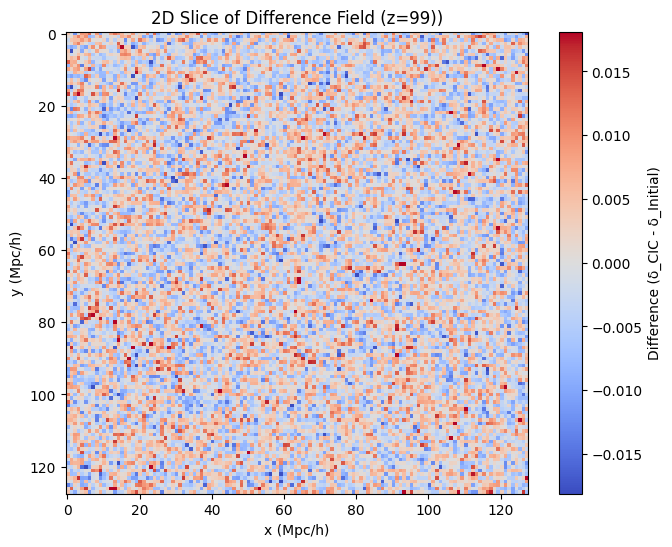

Standard deviation of the Difference Field: 6.040e-03


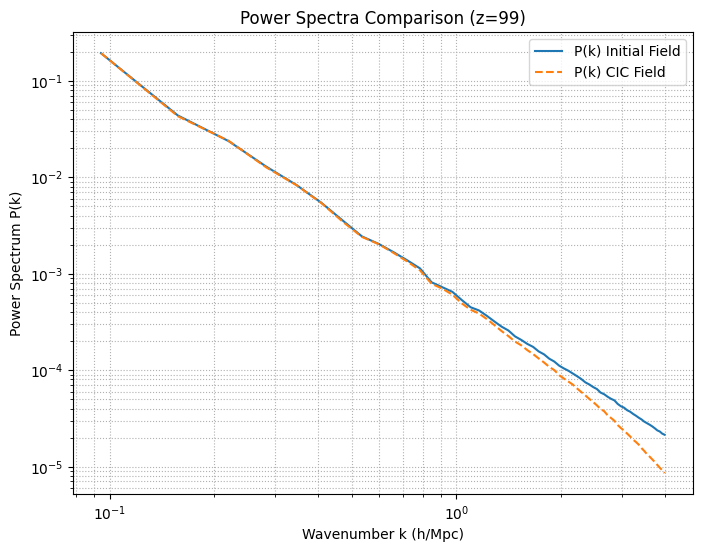

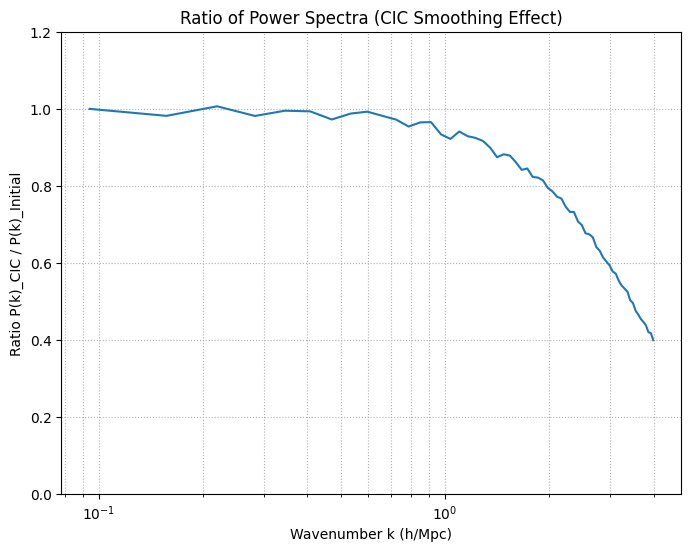

In [ ]:
# Visualizations:
# Plot a 2D slice of the CIC density contrast
delta_cic_density_field = cic_density(positions, N_grid_1d, L)
plt.figure(figsize=(8, 6))
plt.imshow(delta_cic_density_field[N_grid_1d//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N_grid_1d//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_cic_density_field):.3e}")

# Lets create a difference plot to highlight the differences between the initial and
# CIC density field.
diff_field = delta_cic_density_field - initial_density_field

# We can set the min and max std variations for the difference field.
diff_std = np.std(diff_field)
vmin_diff = -3 * diff_std
vmax_diff = 3 * diff_std

plt.figure(figsize=(8, 6))
slice_index = N_grid_1d // 2
plt.imshow(diff_field[slice_index, :, :],
           cmap='coolwarm',
           vmin=vmin_diff,
           vmax=vmax_diff)
plt.colorbar(label='Difference (δ_CIC - δ_Initial)')
plt.title(f'2D Slice of Difference Field (z=99))')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

print(f"Standard deviation of the Difference Field: {diff_std:.3e}")

# Power Spectra Comparison between the initial and CIC field.
import numpy as np

def calculate_power_spectrum_1d(field_3d, L_box, N_grid):
    """Calculates the spherically averaged 1D power spectrum P(k)."""
    if field_3d.shape != (N_grid, N_grid, N_grid):
        raise ValueError(f"Input field must have shape ({N_grid},{N_grid},{N_grid})")

    delta_k = np.fft.fftn(field_3d)
    # Power spectrum P(k) = |delta_k|^2 * (L/N^2)^3 (or similar normalization)
    # Using numpy-fft convention: Normalization is 1/N^3 for ifftn
    # So |delta_k|^2 needs scaling by (L/N)^3 / N^3 = L^3 / N^6 ? Let's check standard def.
    # Often P(k) = V * <|delta_k|^2> / N^6 where V=L^3
    pk_3d = np.abs(delta_k)**2 * (L_box**3) / (N_grid**6)

    # Calculate k modes
    k_nyquist = np.pi * N_grid / L_box
    k_coords = np.fft.fftfreq(N_grid) * 2 * np.pi * N_grid / L_box # k = 2pi*n/L
    kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
    k_magnitude = np.sqrt(kx**2 + ky**2 + kz**2)

    # Binning P(k)
    k_bins = np.linspace(0, k_nyquist, N_grid // 2 + 1)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])

    # Histogram P(k) values into k bins
    # The np.histogram function returns only 2 values (hist, bin_edges) when density=False
    # Change the line to unpack only 2 values.
    pk_1d, _ = np.histogram(
        k_magnitude.flatten(),
        bins=k_bins,
        weights=pk_3d.flatten(),
        density=False
    )

    # Count number of modes in each bin
    counts, _ = np.histogram(
        k_magnitude.flatten(),
        bins=k_bins,
        weights=None,
        density=False
    )

    # Average P(k) in each bin
    pk_1d_avg = np.divide(pk_1d, counts, where=counts > 0, out=np.zeros_like(pk_1d))

    # Often we exclude the k=0 mode (average density)
    return k_bin_centers[1:], pk_1d_avg[1:] # Skip first bin (contains k=0)

# --- Calculate Power Spectra ---
k_initial, pk_initial = calculate_power_spectrum_1d(initial_density_field, L, N_grid_1d)
k_cic, pk_cic = calculate_power_spectrum_1d(delta_cic_density_field, L, N_grid_1d)

# --- Plot Power Spectra ---
plt.figure(figsize=(8, 6))
plt.loglog(k_initial, pk_initial, label='P(k) Initial Field')
plt.loglog(k_cic, pk_cic, label='P(k) CIC Field', linestyle='--')

plt.xlabel('Wavenumber k (h/Mpc)')
plt.ylabel('Power Spectrum P(k)')
plt.title('Power Spectra Comparison (z=99)')
plt.legend()
plt.grid(True, which='both', linestyle=':')
plt.show()

# Optional: Plot the ratio of P(k) to see the CIC window function effect
# Need to interpolate one P(k) onto the other's k-bins if they differ slightly
from scipy.interpolate import interp1d
interp_pk_initial = interp1d(k_initial, pk_initial, bounds_error=False, fill_value=0)
ratio_pk = pk_cic / interp_pk_initial(k_cic)

plt.figure(figsize=(8, 6))
plt.semilogx(k_cic, ratio_pk)
plt.xlabel('Wavenumber k (h/Mpc)')
plt.ylabel('Ratio P(k)_CIC / P(k)_Initial')
plt.title('Ratio of Power Spectra (CIC Smoothing Effect)')
plt.ylim(0, 1.2) # Expect ratio <= 1
plt.grid(True, which='both', linestyle=':')
plt.show()

In [ ]:
@numba.njit
def cic_grav_force(force, positions, N , L):
  h = L / N
  wrapped_pos = positions % L
  interpolated_field = np.zeros_like(positions, dtype=np.float64)
  N_part_total = positions.shape[0]
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h
  xc, yc, zc = np.floor(xp).astype(np.int64), np.floor(yp).astype(np.int64), np.floor(zp).astype(np.int64)
  dx, dy, dz = xp-xc, yp-yc, zp-zc
  tx, ty, tz = 1-dx, 1-dy, 1-dz
  # Grid cell indices via our parent cell indices, taking into account periodic boundary conds.

  for p in range(N_part_total):
    i0, i1 = xc[p] % N, (xc[p]+1) % N
    j0, j1 = yc[p] % N, (yc[p]+1) % N
    k0, k1 = zc[p] % N, (zc[p]+1) % N

    for dim in range(3):
      f = force[dim]
      # Fetching the field values at the 8 neighboring grid points.
      f000 = f[i0, j0, k0]
      f100 = f[i1, j0, k0]
      f010 = f[i0, j1, k0]
      f001 = f[i0, j0, k1]
      f110 = f[i1, j1, k0]
      f011 = f[i0, j1, k1]
      f101 = f[i1, j0, k1]
      f111 = f[i1, j1, k1]

      # Getting the acceleration for each particle, whereby each particle's acceleration is a
      # weighted avg of the forces at the 8 neighboring grid points. (gathering the grid's forces
      # to the particle)
      interpolated_field[p, dim] = (
        f000 * tx[p] * ty[p] * tz[p] +
        f100 * dx[p] * ty[p] * tz[p] +
        f010 * tx[p] * dy[p] * tz[p] +
        f001 * tx[p] * ty[p] * dz[p] +
        f110 * dx[p] * dy[p] * tz[p] +
        f011 * tx[p] * dy[p] * dz[p] +
        f101 * dx[p] * ty[p] * dz[p] +
        f111 * dx[p] * dy[p] * dz[p]
      )

  return interpolated_field

In [ ]:
def get_comoving_acceleration_grid(positions, N_grid, L_box, a_current, cosmo_obj):
  """
  Calculates the comoving acceleration g_c = -grad_c(Phi_c) on the grid.
  Output units: [(km/s)^2 * a^2 / (h * Mpc)]
  """
  # 1. Get density contrast delta on the grid using CIC
  delta_grid = cic_density(positions, N_grid, L_box)

  # 2. Calculate potential Phi in k-space
  delta_k = np.fft.fftn(delta_grid)
  kx, ky, kz, k, k2 = fourier_space(N_grid, L_box)

  # Poisson eq: -k^2 Phi_k = (3/2) * H0^2 * Om0 * a^2 * delta_k
  H0_kms_Mpc = cosmo_obj.H0.to(u.km / u.s / u.Mpc).value
  potential_k = np.zeros_like(delta_k, dtype=complex)
  # Factor includes a^2, so potential_k ~ a^2
  factor = (1.5 * H0_kms_Mpc**2 * cosmo_obj.Om0 * a_current**2)
  # Calculate potential only where k2 is non-zero
  valid_k = k2 > 1e-10 # Avoid division by zero at k=0
  potential_k[valid_k] = - factor * delta_k[valid_k] / k2[valid_k]
  # Units: (km/s)^2 * a^2 / h^2 (if k is h/Mpc) -- Let's re-verify
  # Units check: factor ~ (km/s/Mpc)^2 * a^2. k^2 ~ (h/Mpc)^2
  # potential_k ~ (km/s/Mpc)^2 * a^2 / (h/Mpc)^2 = (km/s)^2 * a^2 / h^2. Correct.

  # 3. Calculate Comoving Force F_c = -grad_c(Phi_c) in k-space
  # F_c_k = -i * k * Phi_k
  force_k = np.zeros((3,) + delta_k.shape, dtype=complex)
  k_vec = [kx, ky, kz]
  for i in range(3):
      # Multiply by k (units h/Mpc)
      force_k[i][valid_k] = -1j * k_vec[i][valid_k] * potential_k[valid_k]
      # Units: (h/Mpc) * (km/s)^2 * a^2 / h^2 = (km/s)^2 * a^2 / (h * Mpc). Correct.

  # 4. Inverse FFT to get Comoving acceleration g_c = F_c on the grid
  g_comov_grid = np.zeros((3,) + delta_k.shape, dtype=float) # Use float for real part
  for i in range(3):
      g_comov_grid[i] = np.real(np.fft.ifftn(force_k[i]))
      # Units: (km/s)^2 * a^2 / (h * Mpc). Correct.

  return g_comov_grid

In [ ]:
g_comov_grid = get_comoving_acceleration_grid(positions, N_grid_1d, L, a, cosmo)
g_comov_particles = cic_grav_force(g_comov_grid, positions, N_grid_1d, L)

In [ ]:
print(f"g_comov_grid units: {g_comov_grid.dtype}")
print(f"g_comov_particles units: {g_comov_particles.dtype}")
print(f"g_comov_grid shape: {g_comov_grid.shape}")
print(f"g_comov_particles shape: {g_comov_particles.shape}")

g_comov_grid units: float64
g_comov_particles units: float64
g_comov_grid shape: (3, 128, 128, 128)
g_comov_particles shape: (2097152, 3)


Mean comoving acceleration: 7.117e-03 (simulation units)
Max comoving acceleration: 1.900e-02 (simulation units)


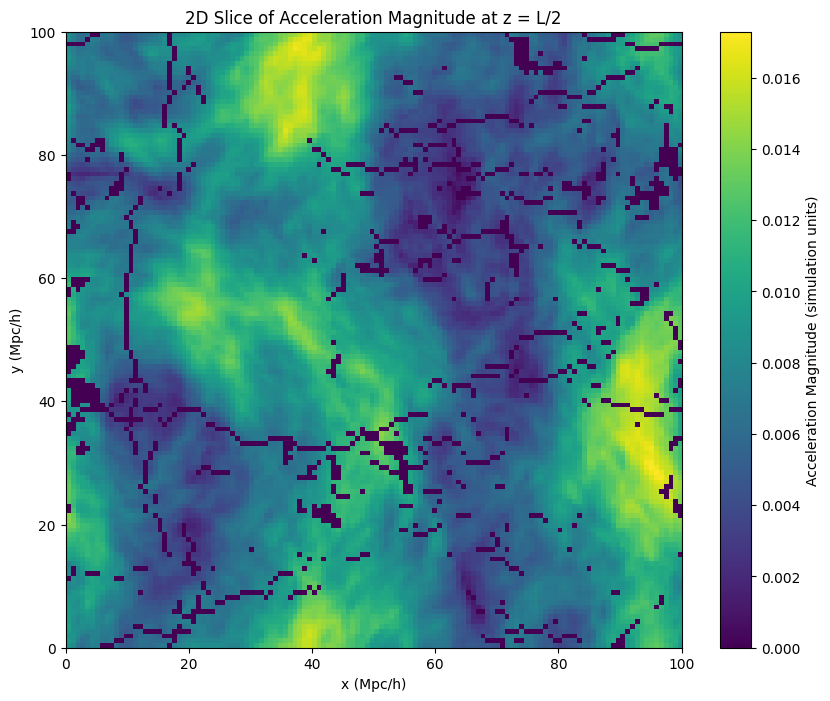

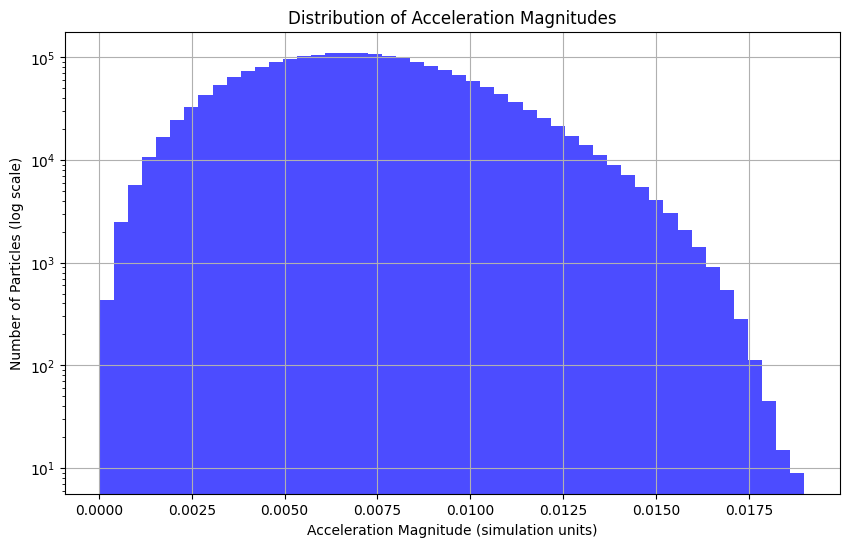

In [ ]:
# 2D Acceleration Magnitude Map:
# Compute acceleration magnitudes
accel_magnitude = np.sqrt(np.sum(g_comov_particles**2, axis=1))

print(f"Mean comoving acceleration: {np.mean(accel_magnitude):.3e} (simulation units)")
print(f"Max comoving acceleration: {np.max(accel_magnitude):.3e} (simulation units)")

# Define a function to grid the magnitudes (similar to CIC but simpler averaging)
def grid_magnitudes(positions, magnitudes, N, L):
  h = L / N
  grid = np.zeros((N, N, N))
  counts = np.zeros((N, N, N))
  indices = (positions / h).astype(int) % N  # Grid indices with periodic boundaries
  # Reshape magnitudes to be 1D
 # magnitudes = magnitudes.flatten()
  np.add.at(grid, (indices[:, 0], indices[:, 1], indices[:, 2]), magnitudes)
  np.add.at(counts, (indices[:, 0], indices[:, 1], indices[:, 2]), 1)
  counts[counts == 0] = 1  # Avoid division by zero
  return grid / counts

# Grid the acceleration magnitudes
accel_grid = grid_magnitudes(positions, accel_magnitude, N_grid_1d, L)

# Plot a 2D slice
plt.figure(figsize=(10, 8))
plt.imshow(accel_grid[N_grid_1d//2, :, :], cmap='viridis', extent=[0, L, 0, L])
plt.colorbar(label='Acceleration Magnitude (simulation units)')
plt.title('2D Slice of Acceleration Magnitude at z = L/2')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Histogram of the Acceleration Magnitudes:
# Compute acceleration magnitudes (if not already done)
accel_magnitude = np.sqrt(np.sum(g_comov_particles**2, axis=1))

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(accel_magnitude, bins=50, log=True, color='blue', alpha=0.7)
plt.title('Distribution of Acceleration Magnitudes')
plt.xlabel('Acceleration Magnitude (simulation units)')
plt.ylabel('Number of Particles (log scale)')
plt.grid(True)
plt.show()

In [ ]:
# Need CIC interpolation function available (defined previously)
# def cic_interpolate_field(field_on_grid, positions, N_grid, L_box): ...

def get_physical_peculiar_acceleration(g_comov_particles, a_current, cosmo_obj):
  """
  Calculates the physical peculiar acceleration g_pec needed by the integrator.
  Takes comoving acceleration particles (accelerations in each direction) as input.
  Output units: [km/s/Myr]
  """
  # g_comov_particles units: (km/s)^2 * a^2 / (h * Mpc)

  # 2. Convert to physical acceleration and apply unit conversion for integrator
  # Physical accel g_phys = g_comov / a^2 ??? No, should be g_phys = g_comov / a? Let's re-derive g = -grad(Phi)
  # Phi_phys = Phi_comov. g_phys = -grad_phys(Phi_phys) = -(1/a)grad_comov(Phi_comov) = g_comov / a.
  # So, g_pec_particles has units: [(km/s)^2 * a^2 / (h * Mpc)] / a = (km/s)^2 * a / (h * Mpc)
  g_pec_particles = g_comov_particles / a_current # Units: (km/s)^2 * a / (h * Mpc)

  # Conversion factor to get km/s/Myr
  Myr_to_s = (1 * u.Myr).to(u.s).value
  Mpc_to_km = (1 * u.Mpc).to(u.km).value
  h = cosmo_obj.h
  # Previous derivation: factor converts units of [(km/s)^2 / (h * Mpc)] to [km / (s * Myr)]
  # Let's call intermediate g_pec = g_comov_particles / a_current
  # Units of intermediate g_pec: (km/s)^2 * a / (h * Mpc)
  # Unit conversion factor: Myr_to_s / (Mpc_to_km / h) --> Units: s * Myr^-1 * Mpc * h * km^-1

  # Let's apply the conversion to g_comov_particles and then divide by 'a'
  # unit_conversion_factor = Myr_to_s / (Mpc_to_km / h)
  # temp_accel = g_comov_particles * unit_conversion_factor # Units: km/s/Myr * a^2
  # g_pec_kms_Myr = temp_accel / a_current # Units: km/s/Myr * a --> WRONG

  # Let's retry the factor from the previous thought process:
  # g_phys_kms_Myr = g_comov_particles * unit_conversion_factor / (a_current)
  unit_conversion_factor = Myr_to_s / (Mpc_to_km / h)
  g_pec_kms_Myr = g_pec_particles * unit_conversion_factor
  # Check units: [(km/s)^2*a^2/(h*Mpc)] * [s*Myr^-1*Mpc*h*km^-1] / a^2
  # = [km*s^-1*Myr^-1*a^2] / a^2 = km/s/Myr. This looks correct.

  return g_pec_kms_Myr # Should be in km/s/Myr

In [ ]:
pec = get_physical_peculiar_acceleration(g_comov_particles, a, cosmo)
print(f"pec units: {pec.dtype}")
print(f"pec shape: {pec.shape}")

pec units: float64
pec shape: (2097152, 3)


In [ ]:
import time

def leapfrog_kdk_a(initial_positions, initial_velocities, N_grid, L_box, a_start, a_end, steps, cosmo_obj, snapshots_a=None):
  """ Performs KDK leapfrog integration using scale factor 'a'. """
  positions_history = [initial_positions.copy()]
  v_pec_current = initial_velocities.copy() # km/s
  pos_current = initial_positions.copy()    # Mpc/h
  a_current = a_start
  da = (a_end - a_start) / steps
  h_cosmo = cosmo_obj.h

  print(f"Starting KDK Leapfrog Integration with 'a':")
  print(f"a_start={a_start:.4f}, a_end={a_end:.4f}, steps={steps}, da={da:.2e}")

  # Saving 'snapshots' of our positions at specific intermediate scaling factors.
  positions_snapshots = {}
  if snapshots_a is None:
    snapshots_a = [a_end]
  else:
    snapshots_a = sorted([s for s in snapshots_a if s > a_start and s <= a_end])

  positions_snapshots[a_start] = initial_positions.copy()
  next_snap_idx = 0


  # Calculate initial acceleration g_pec(a_start) for the first kick
  z_current = 1.0 / a_current - 1.0
  g_comov_grid_current = get_comoving_acceleration_grid(pos_current, N_grid, L_box, a_current, cosmo_obj)
  g_comov_particles_current = cic_grav_force(g_comov_grid_current, pos_current, N_grid, L_box)
  g_pec_current = get_physical_peculiar_acceleration(g_comov_particles_current, a_current, cosmo_obj) # km/s/Myr.

  # Conversion factors involving H(a) often needed inside loop
  Myr_in_s = (1 * u.Myr).to(u.s).value
  km_per_Mpc = (1 * u.Mpc).to(u.km).value

  # Starting time.
  start_time = time.time()
  last_print_time = start_time

  # Main integration loop
  for step in range(steps):
    # Storing the scaling factor a before the update for the snapshot check.
    a_prev = a_current

    # --- Kick 1 (Update v_pec by da/2 using g_pec at a) ---
    z_current = 1.0 / a_current - 1.0
    if z_current < 0: z_current = 0 # Avoid issues near a=1
    H_a = cosmo_obj.H(z_current).to(u.km / u.s / u.Mpc).value # km/s/Mpc

    # dv/da = g_pec / (a*H) - v/a
    # Units: dv/da = (km/s/Myr) / (a * km/s/Mpc) - (km/s)/a
    # Need H in km/s/Myr per Mpc ? H_myr = H_a * km_per_Mpc / Myr_in_s ? No.
    # H_a [km/s/Mpc]. G(a) = 1/(a*H_a) [s*Mpc/km / a] ?
    # Let's convert H to 1/Myr: H_a_myr = H_a * (u.km / u.s / u.Mpc).to(1 / u.Myr)
    H_a_myr = H_a * (Myr_in_s / km_per_Mpc) # Units: 1/Myr

    # Term 1: g_pec / (a * H_a_phys) where H_a_phys is in 1/Myr
    term1 = g_pec_current / (a_current * H_a_myr) # (km/s/Myr) / (1/Myr) = km/s
    # Term 2: - v_pec / a
    term2 = - v_pec_current / a_current # km/s
    dv_da = term1 + term2 # km/s

    v_half = v_pec_current + dv_da * (da / 2.0)

    # --- Drift (Update pos by da using v_half at a_mid) ---
    a_mid = a_current + da / 2.0
    z_mid = 1.0 / a_mid - 1.0
    if z_mid < 0: z_mid = 0
    H_mid = cosmo_obj.H(z_mid).to(u.km / u.s / u.Mpc).value # km/s/Mpc

    # dx/da = v_pec / (a^2 * H)
    # Units: dx/da = (km/s) / (a^2 * km/s/Mpc) = Mpc / a^2
    # Need result in Mpc/h. H is km/s/Mpc.
    # dx/da = v_half / (a_mid**2 * H_mid) # Units: Mpc
    delta_pos_mpc = (v_half / (a_mid**2 * H_mid)) * da # Units: Mpc
    delta_pos_mpch = delta_pos_mpc * h_cosmo # Convert Mpc to Mpc/h

    pos_current += delta_pos_mpch
    pos_current %= L_box # Periodic boundaries

    # --- Update a and calculate g_pec at new position and time ---
    a_new = a_current + da
    g_comov_grid_new = get_comoving_acceleration_grid(pos_current, N_grid, L_box, a_new, cosmo_obj)
    g_comov_particles_new = cic_grav_force(g_comov_grid_new, pos_current, N_grid, L_box)
    g_pec_new = get_physical_peculiar_acceleration(g_comov_particles_new, a_new, cosmo_obj) # km/s/Myr

    # --- Kick 2 (Update v_pec by da/2 using g_pec at a_new) ---
    z_new = 1.0 / a_new - 1.0
    if z_new < 0: z_new = 0
    H_new = cosmo_obj.H(z_new).to(u.km / u.s / u.Mpc).value # km/s/Mpc
    H_new_myr = H_new * (Myr_in_s / km_per_Mpc) # Units: 1/Myr

    term1_new = g_pec_new / (a_new * H_new_myr) # km/s
    # Use v_half for the drag term, consistent with KDK formulation
    term2_new = - v_half / a_new # km/s
    dv_da_new = term1_new + term2_new # km/s

    v_pec_new = v_half + dv_da_new * (da / 2.0)

    # --- Update current state for next step ---
    v_pec_current = v_pec_new
    a_current = a_new
    g_pec_current = g_pec_new # Store for next Kick 1
    final_g_comov_grid = g_comov_grid_new

    # Store history (optional, can be memory intensive)
    # positions_history.append(pos_current.copy())

    # Checking for saving snapshot.
    if next_snap_idx < len(snapshots_a):
      target_a = snapshots_a[next_snap_idx]
      if a_prev < target_a <= a_current:
        print(f"Saving snapshot at a={a_current:.4f} (target near {target_a:.4f})")
        positions_snapshots[a_current] = pos_current.copy()
        next_snap_idx += 1

    # Print status.
    if (step + 1) % (steps // 10) == 0 or step == steps - 1: # Print status periodically.
      current_time = time.time()
      time_since_last = current_time - last_print_time
      total_elapsed_time = current_time - start_time
      # Determining the time per step for this step interval.
      steps_since_last = (steps // 10) if (step + 1) % (steps // 10) == 0 else (step + 1) % (steps // 10)
      time_per_step = time_since_last / steps_since_last if steps_since_last > 0 else 0

      max_v = np.max(np.sqrt(np.sum(v_pec_current**2, axis=1)))
      max_g = np.max(np.sqrt(np.sum(g_pec_current**2, axis=1)))
      print(f"Step {step+1}/{steps}: a = {a_current:.4f}, z = {1/a_current - 1:.4f}, H = {H_new:.4f} km/s/Mpc, Max v = {max_v:.4f} km/s, Max g_pec = {max_g:.4f} km/s/Myr")
      print(f"Interval: {time_since_last:.2f} s ({time_per_step:.3f} s/step) | total: {total_elapsed_time}")
      last_print_time = current_time

  # Making sure the final state is saved if needed:
  if snapshots_a:
    if a_end in snapshots_a and a_end not in positions_snapshots:
      print(f"Saving the final snapshot at a = {a_current:.4f} (target {a_end:.4f})")
      positions_snapshots[a_current] = pos_current.copy()
    elif a_end not in positions_snapshots:
      positions_snapshots[a_current] = pos_current.copy()

  # Final timing after integration is done:
  end_time = time.time()
  total_sim_time = end_time - start_time
  avg_time_per_step = total_sim_time / (steps) if steps > 0 else 0

  print(f"Finished KDK Leapfrog. Final a = {a_current:.6f}")
  print(f"Total simulation time: {total_sim_time:.2f} seconds")
  print(f"Average time per step: {avg_time_per_step:.6f} seconds")
  return positions_history, positions_snapshots, v_pec_current, pos_current, final_g_comov_grid # Return last state

In [ ]:
snapshot_a_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# --- Run the Simulation (a-based KDK) ---
print("\nRunning KDK Integration with 'a'")
positions_history, positions_snapshots, v_pec_current, pos_current, final_g_comov_grid = leapfrog_kdk_a(
    positions,
    velocities,
    N_grid_1d,
    L,
    a_initial,
    a_final,
    num_steps,
    cosmo,
    snapshots_a=snapshot_a_values)

final_a_key = max(positions_snapshots.keys())
final_position_a = positions_snapshots[final_a_key]

print(f"Available snapshots saved at a= {sorted(positions_snapshots.keys())}")


Running KDK Integration with 'a'
Starting KDK Leapfrog Integration with 'a':
a_start=0.0100, a_end=1.0000, steps=1000, da=9.90e-04
Saving snapshot at a=0.1001 (target near 0.1000)
Step 100/1000: a = 0.1090, z = 8.1743, H = 1049.2370 km/s/Mpc, Max v = 4.5649 km/s, Max g_pec = 0.0000 km/s/Myr
Interval: 92.38 s (0.924 s/step) | total: 92.37708973884583
Saving snapshot at a=0.2001 (target near 0.2000)
Step 200/1000: a = 0.2080, z = 3.8077, H = 401.1631 km/s/Mpc, Max v = 2.4318 km/s, Max g_pec = 0.0001 km/s/Myr
Interval: 94.87 s (0.949 s/step) | total: 187.24704241752625
Saving snapshot at a=0.3001 (target near 0.3000)
Step 300/1000: a = 0.3070, z = 2.2573, H = 228.4865 km/s/Mpc, Max v = 1.7420 km/s, Max g_pec = 0.0001 km/s/Myr
Interval: 95.16 s (0.952 s/step) | total: 282.41073274612427
Saving snapshot at a=0.4001 (target near 0.4000)
Step 400/1000: a = 0.4060, z = 1.4631, H = 156.0769 km/s/Mpc, Max v = 1.4760 km/s, Max g_pec = 0.0001 km/s/Myr
Interval: 94.14 s (0.941 s/step) | total: 376


--- Initial vs Final Particle Positions ---


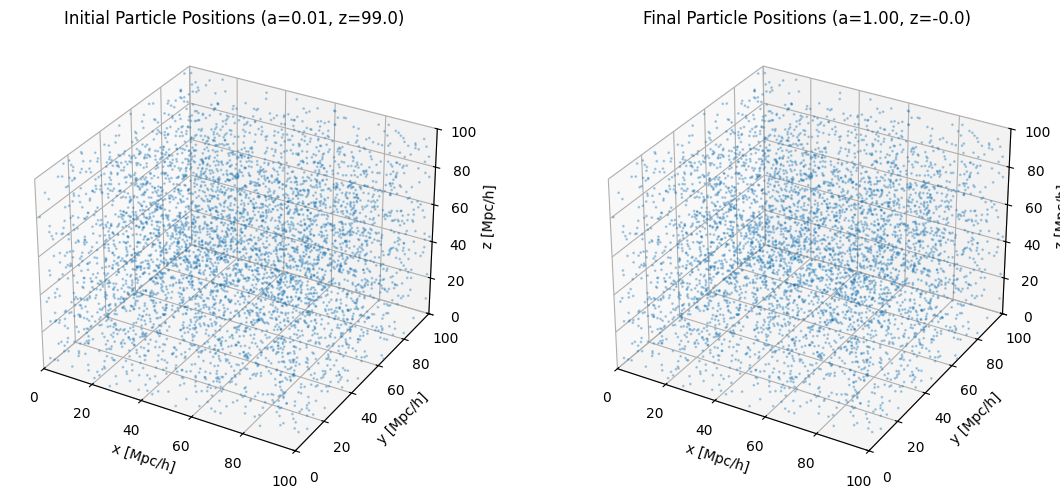


--- Initial vs Final Density Contrast Slices ---


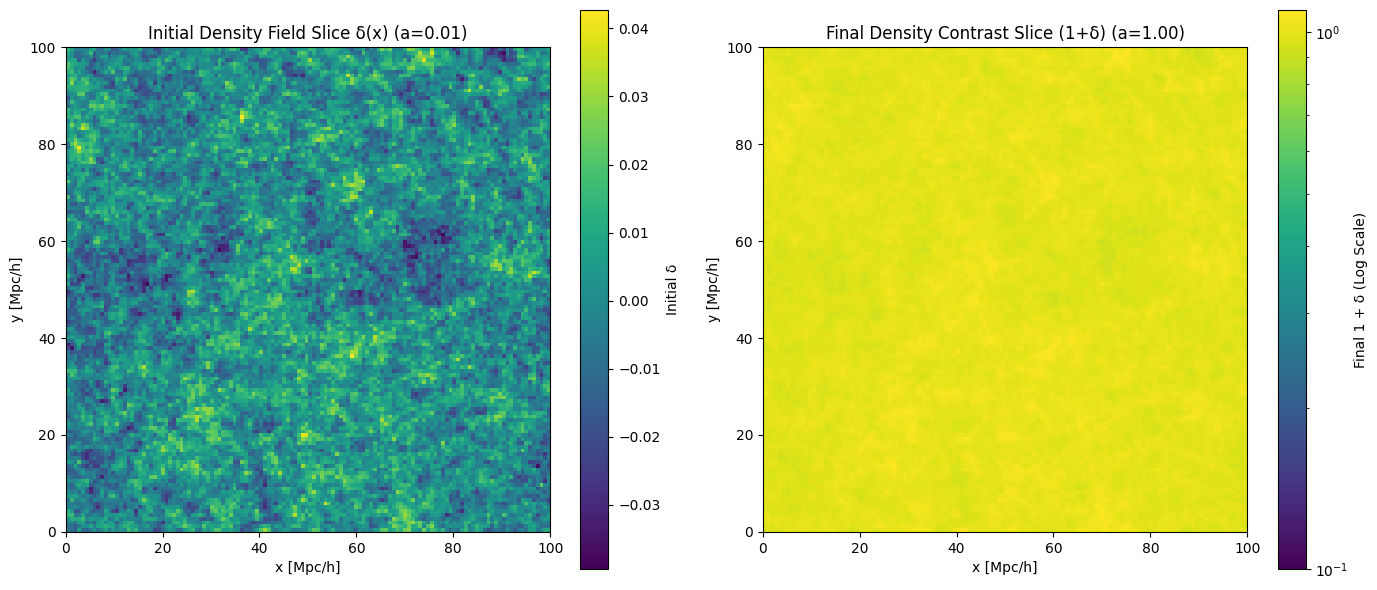

Standard deviation of initial δ: 1.0934e-02
Standard deviation of final δ: 2.6442e-02
Min/Max of initial δ: -5.6731e-02 / 5.3333e-02
Min/Max of final δ: -1.1446e-01 / 1.9264e-01


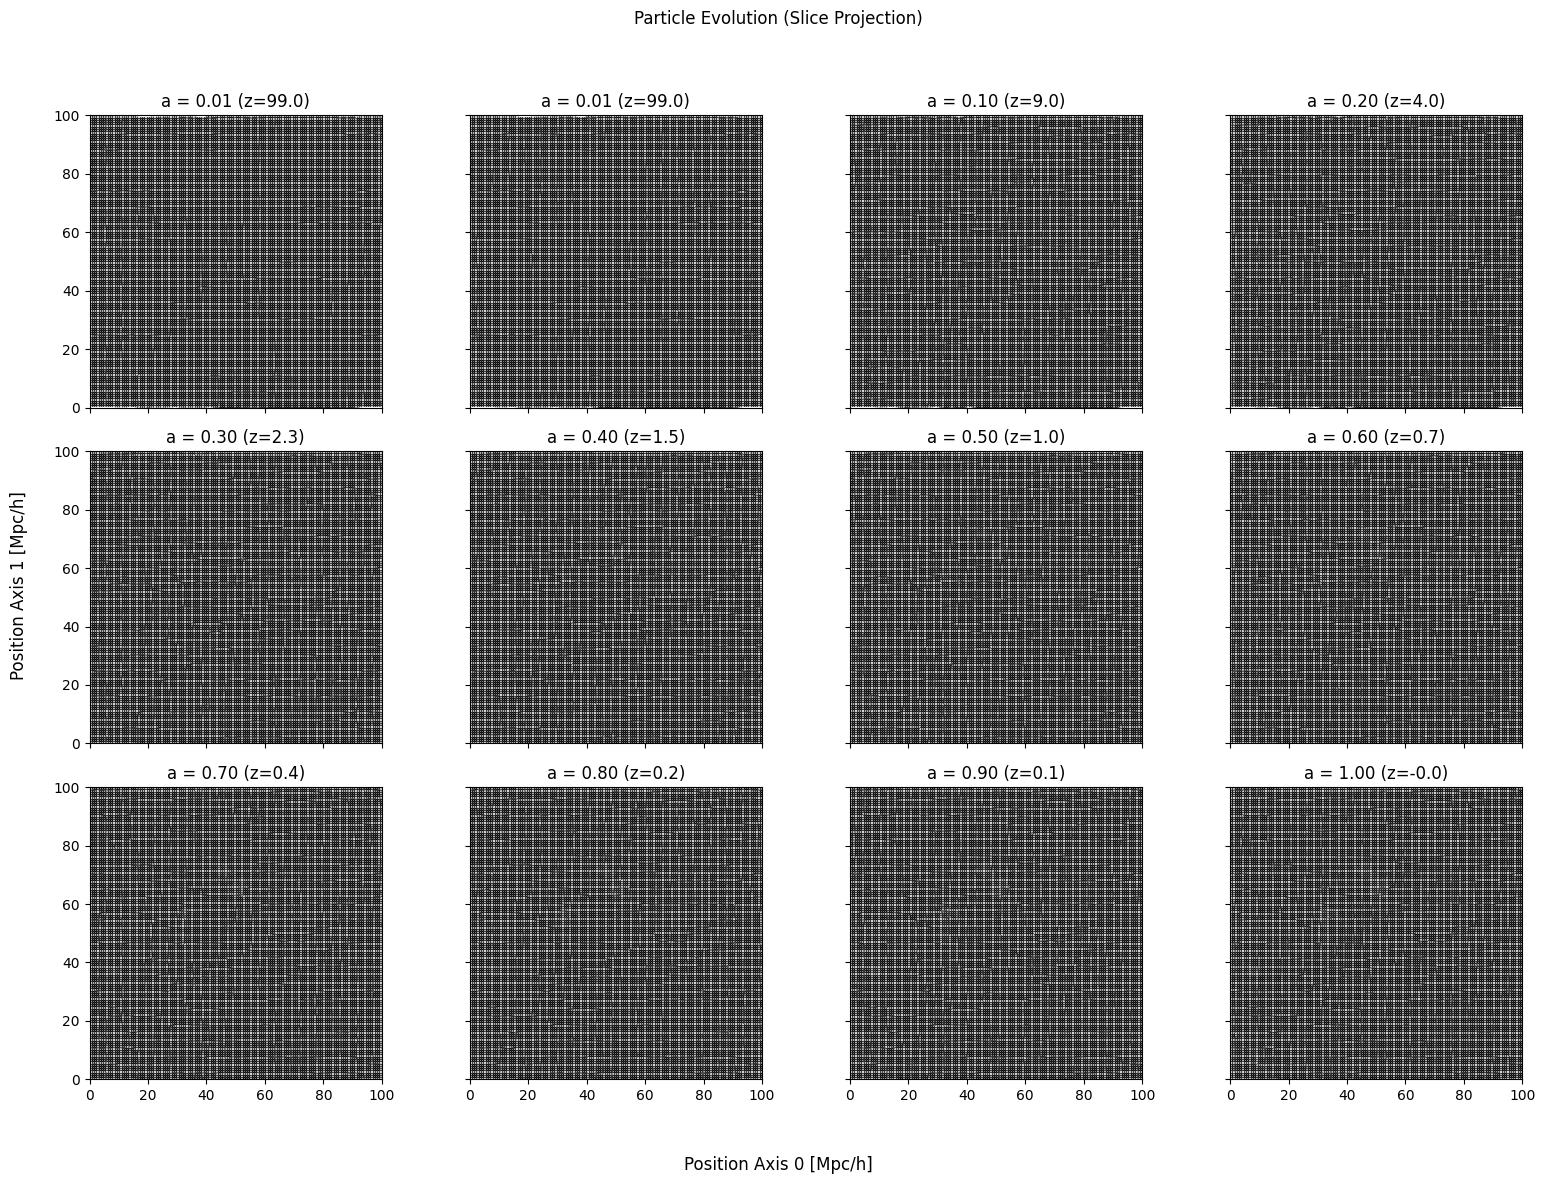


--- Density Contrast Evolution (2D Slices) ---


<ipython-input-23-85ddc81d208a>:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout


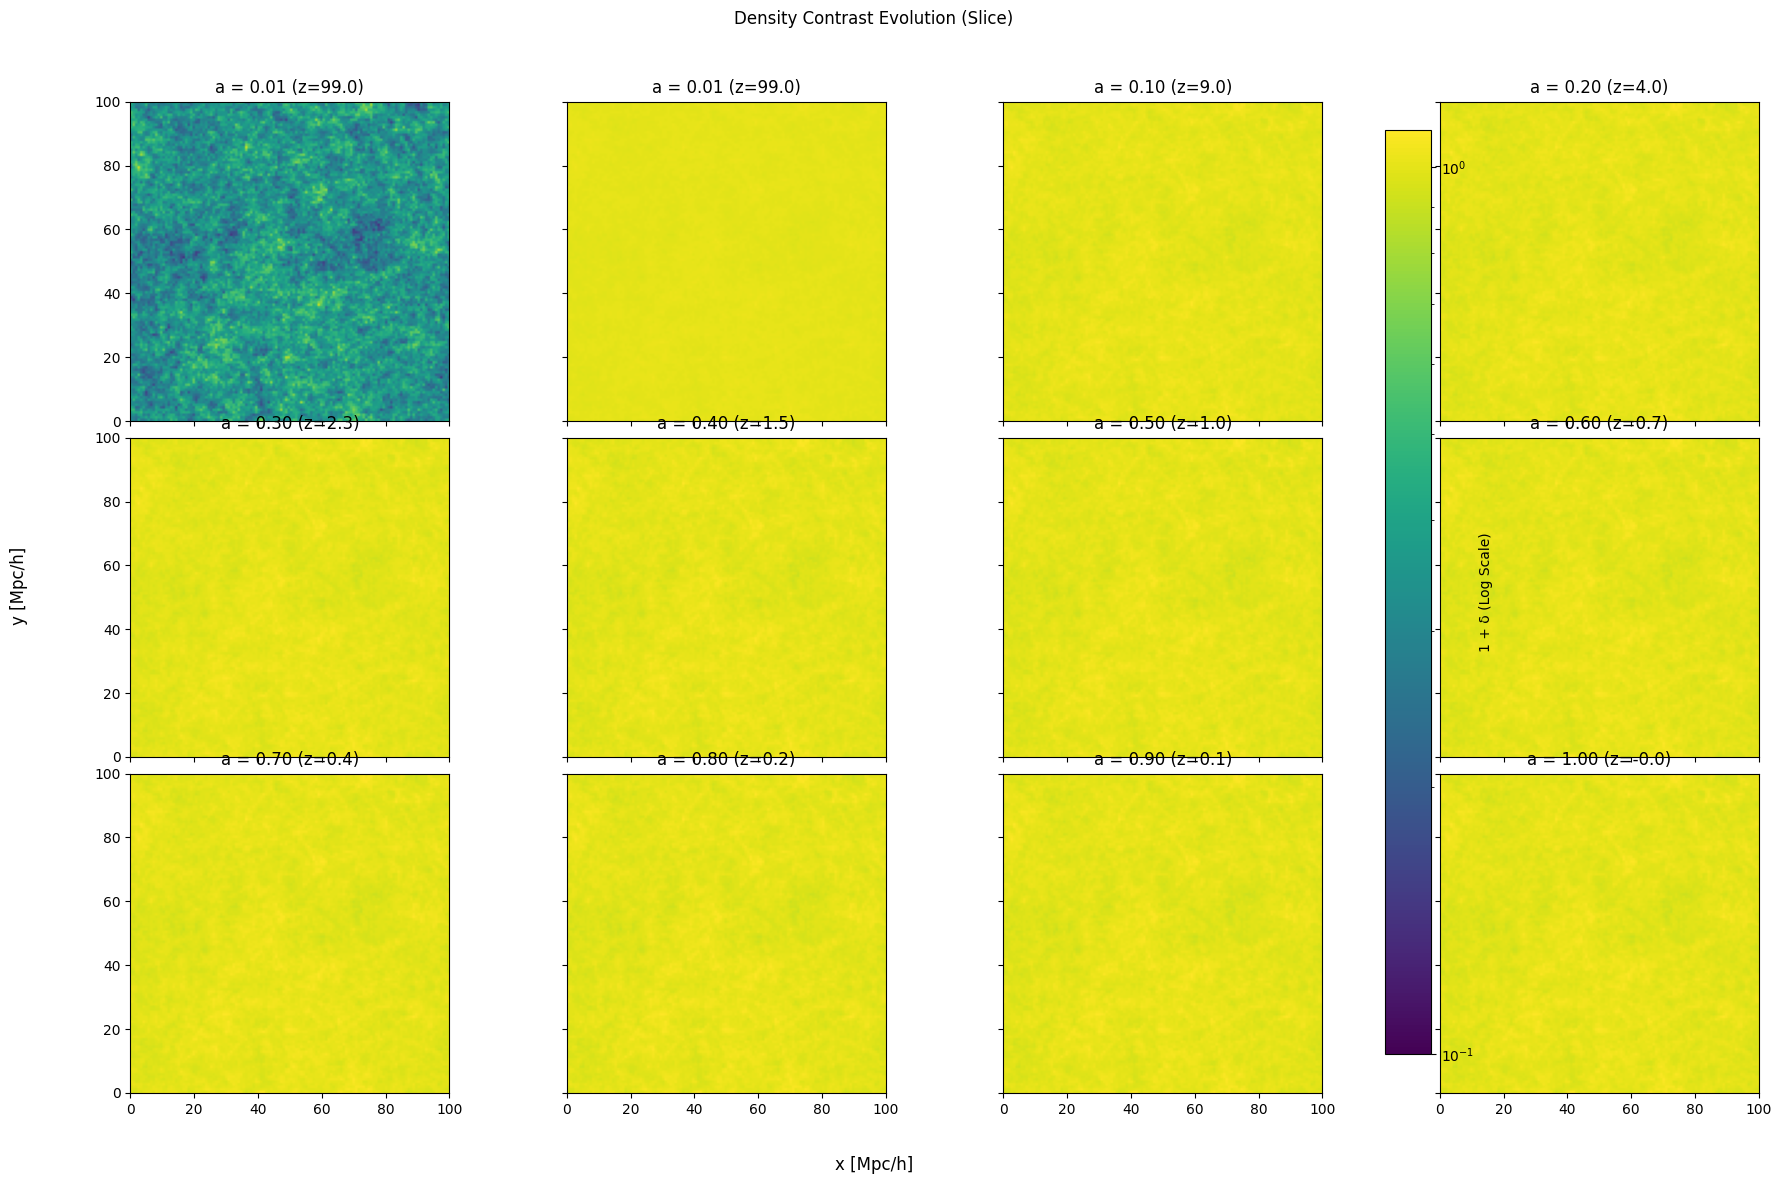

In [ ]:
# Visualizations:
print("\n--- Initial vs Final Particle Positions ---")
# Use a smaller subset for 3D plotting if N_particles_1d is large (e.g., 256)
if N_particles_1d > 64:
    subset_size = 5000 # Adjust as needed for performance/clarity
else:
    subset_size = N_particles_1d**3 # Plot all if small enough
subset_indices = np.random.choice(N_particles_1d**3, subset_size, replace=False)

fig = plt.figure(figsize=(12, 5))

# Initial Positions
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(positions[subset_indices, 0], positions[subset_indices, 1], positions[subset_indices, 2],
            s=1, alpha=0.3) # Smaller points for dense plots
ax1.set_title(f"Initial Particle Positions (a={a_initial:.2f}, z={1/a_initial-1:.1f})")
ax1.set_xlabel("x [Mpc/h]")
ax1.set_ylabel("y [Mpc/h]")
ax1.set_zlabel("z [Mpc/h]")
ax1.set_xlim(0, L)
ax1.set_ylim(0, L)
ax1.set_zlim(0, L)

# Final Positions
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_position_a[subset_indices, 0], final_position_a[subset_indices, 1], final_position_a[subset_indices, 2],
            s=1, alpha=0.3)
ax2.set_title(f"Final Particle Positions (a={final_a_key:.2f}, z={1/final_a_key-1:.1f})")
ax2.set_xlabel("x [Mpc/h]")
ax2.set_ylabel("y [Mpc/h]")
ax2.set_zlabel("z [Mpc/h]")
ax2.set_xlim(0, L)
ax2.set_ylim(0, L)
ax2.set_zlim(0, L)

plt.tight_layout()
plt.show()

print("\n--- Initial vs Final Density Contrast Slices ---")

# Calculate final density contrast using the correct function
# Ensure cic_density is the function defined for the a-based simulation
delta_final = cic_density(final_position_a, N_grid_1d, L)

# Choose a slice index
slice_idx = N_grid_1d // 2

# Determine common color scale limits based on final density
vmin_delta = -0.9 # Allow seeing voids, min delta is -1
vmax_delta = np.percentile(delta_final, 99.5) # Clip extreme peaks for better color scale
norm_delta = plt.cm.colors.LogNorm(vmin=0.1, vmax=max(1.1, vmax_delta + 1)) # LogNorm on 1+delta requires vmin > 0
# Alternative: Linear scale
# vmax_delta = np.percentile(delta_final, 99.5)
# vmin_delta = np.percentile(delta_final, 0.5) # Or min(0, np.percentile(delta_final, 0.5))
# norm_delta = plt.cm.colors.Normalize(vmin=min(-0.9, vmin_delta), vmax=vmax_delta)


fig_dens, axes_dens = plt.subplots(1, 2, figsize=(14, 6))

# Initial Density Field Slice
im0 = axes_dens[0].imshow(initial_density_field[:, :, slice_idx].T, # Transpose check needed? Often imshow expects (row, col) -> (y,x)
                         origin='lower', extent=[0, L, 0, L],
                         cmap='viridis',
                         aspect='equal') # Use linear scale for initial field
axes_dens[0].set_title(f'Initial Density Field Slice δ(x) (a={a_initial:.2f})')
axes_dens[0].set_xlabel('x [Mpc/h]')
axes_dens[0].set_ylabel('y [Mpc/h]')
plt.colorbar(im0, ax=axes_dens[0], label='Initial δ')


# Final Density Contrast Slice (use LogNorm for 1+delta)
im1 = axes_dens[1].imshow(1 + delta_final[:, :, slice_idx].T,
                         origin='lower', extent=[0, L, 0, L],
                         cmap='viridis',
                         norm=norm_delta,
                         aspect='equal')
axes_dens[1].set_title(f'Final Density Contrast Slice (1+δ) (a={final_a_key:.2f})')
axes_dens[1].set_xlabel('x [Mpc/h]')
axes_dens[1].set_ylabel('y [Mpc/h]')
plt.colorbar(im1, ax=axes_dens[1], label='Final 1 + δ (Log Scale)')


plt.tight_layout()
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.4e}")
print(f"Standard deviation of final δ: {np.std(delta_final):.4e}")
print(f"Min/Max of initial δ: {np.min(initial_density_field):.4e} / {np.max(initial_density_field):.4e}")
print(f"Min/Max of final δ: {np.min(delta_final):.4e} / {np.max(delta_final):.4e}")

# Visualization of the evolution of the sim via usage of the snapshots saved.
# Choose a thin slice for 2D projection
slice_thickness = L * 0.05 # 5% slice depth
slice_axis = 2 # Project along z-axis
pos_axes = [0, 1] # Plot x vs y

# Determine number of plots needed (initial + snapshots)
plot_keys = sorted(positions_snapshots.keys())
num_plots = 1 + len(plot_keys) # Add 1 for the initial state
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

fig_part_evol, axes_part_evol = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharex=True, sharey=True)
axes_part_evol = axes_part_evol.flatten() # Flatten for easy indexing

# Plot Initial State
slice_center_init = L / 2.0 # Or choose dynamically
select_init = np.abs(positions[:, slice_axis] - slice_center_init) < (slice_thickness / 2.0)
axes_part_evol[0].scatter(positions[select_init, pos_axes[0]], positions[select_init, pos_axes[1]],
                          s=0.1, alpha=0.5, c='k') # Use small black dots
axes_part_evol[0].set_title(f"a = {a_initial:.2f} (z={1/a_initial-1:.1f})")
axes_part_evol[0].set_aspect('equal', adjustable='box')

# Plot Snapshots
for i, a_snap in enumerate(plot_keys):
    ax = axes_part_evol[i+1]
    snap_positions = positions_snapshots[a_snap]
    slice_center_snap = L / 2.0
    select_snap = np.abs(snap_positions[:, slice_axis] - slice_center_snap) < (slice_thickness / 2.0)
    ax.scatter(snap_positions[select_snap, pos_axes[0]], snap_positions[select_snap, pos_axes[1]],
               s=0.1, alpha=0.5, c='k')
    ax.set_title(f"a = {a_snap:.2f} (z={1/a_snap-1:.1f})")
    ax.set_aspect('equal', adjustable='box')

# Add labels, limits, and remove unused axes
for ax in axes_part_evol:
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
for i in range(num_plots, len(axes_part_evol)): # Hide unused subplots
    axes_part_evol[i].set_visible(False)
# Add shared labels
fig_part_evol.supxlabel(f"Position Axis {pos_axes[0]} [Mpc/h]")
fig_part_evol.supylabel(f"Position Axis {pos_axes[1]} [Mpc/h]")
fig_part_evol.suptitle("Particle Evolution (Slice Projection)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
plt.show()


print("\n--- Density Contrast Evolution (2D Slices) ---")

# Use the same slice index as before
# slice_idx = N_grid_1d // 2

# Determine common color scale for all density plots (using final state)
delta_final = cic_density(positions_snapshots[final_a_key], N_grid_1d, L)
vmin_delta_log = 0.1 # Min for log scale (1+delta)
vmax_delta_log = max(1.1, np.percentile(1 + delta_final, 99.8)) # Use higher percentile for evolution
norm_delta_log = plt.cm.colors.LogNorm(vmin=vmin_delta_log, vmax=vmax_delta_log)

fig_dens_evol, axes_dens_evol = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4), sharex=True, sharey=True)
axes_dens_evol = axes_dens_evol.flatten()

# Plot Initial State (use linear scale here)
norm_initial = plt.cm.colors.Normalize(vmin=np.min(initial_density_field), vmax=np.max(initial_density_field))
im_init_dens = axes_dens_evol[0].imshow(initial_density_field[:, :, slice_idx].T,
                                      origin='lower', extent=[0, L, 0, L],
                                      cmap='viridis', norm=norm_initial, aspect='equal')
axes_dens_evol[0].set_title(f"a = {a_initial:.2f} (z={1/a_initial-1:.1f})")
# plt.colorbar(im_init_dens, ax=axes_dens_evol[0], label='Initial δ') # Optional individual colorbar

# Plot Snapshots (use log scale for 1+delta)
ims = [] # To store image objects for a single colorbar
for i, a_snap in enumerate(plot_keys):
    ax = axes_dens_evol[i+1]
    snap_positions = positions_snapshots[a_snap]
    delta_snap = cic_density(snap_positions, N_grid_1d, L)
    im = ax.imshow(1 + delta_snap[:, :, slice_idx].T,
                   origin='lower', extent=[0, L, 0, L],
                   cmap='viridis', norm=norm_delta_log, aspect='equal')
    ims.append(im)
    ax.set_title(f"a = {a_snap:.2f} (z={1/a_snap-1:.1f})")

# Add labels, limits, and remove unused axes
for ax in axes_dens_evol:
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
for i in range(num_plots, len(axes_dens_evol)): # Hide unused subplots
    axes_dens_evol[i].set_visible(False)

# Add a single colorbar for the snapshots
fig_dens_evol.colorbar(ims[-1], ax=axes_dens_evol[:num_plots], orientation='vertical', label='1 + δ (Log Scale)')

# Add shared labels
fig_dens_evol.supxlabel("x [Mpc/h]")
fig_dens_evol.supylabel("y [Mpc/h]")
fig_dens_evol.suptitle("Density Contrast Evolution (Slice)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

Using a subset of 5000 particles for the scatter plots.
n\-- Plotting Final Particle Distribution --


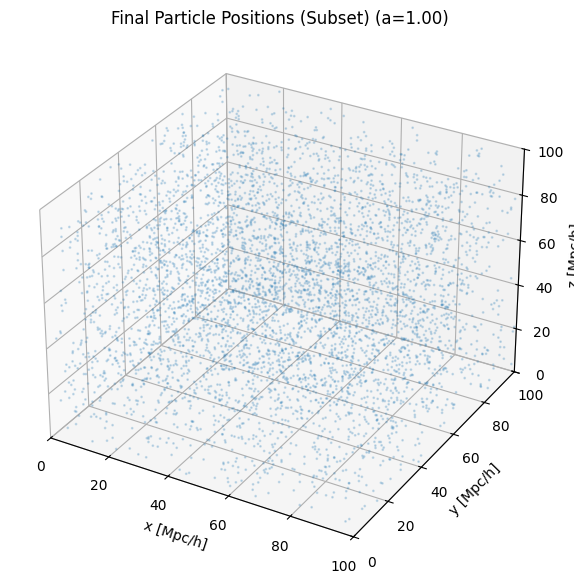

114428 particles in the 2D slice.
Plotting a random subset of 20000 particles from the slice.


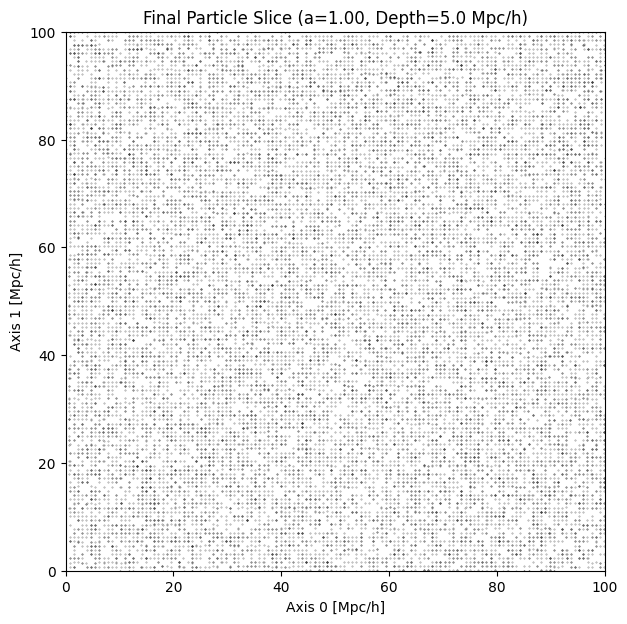


--- Plotting Final Density Contrast ---


NameError: name 'colors' is not defined

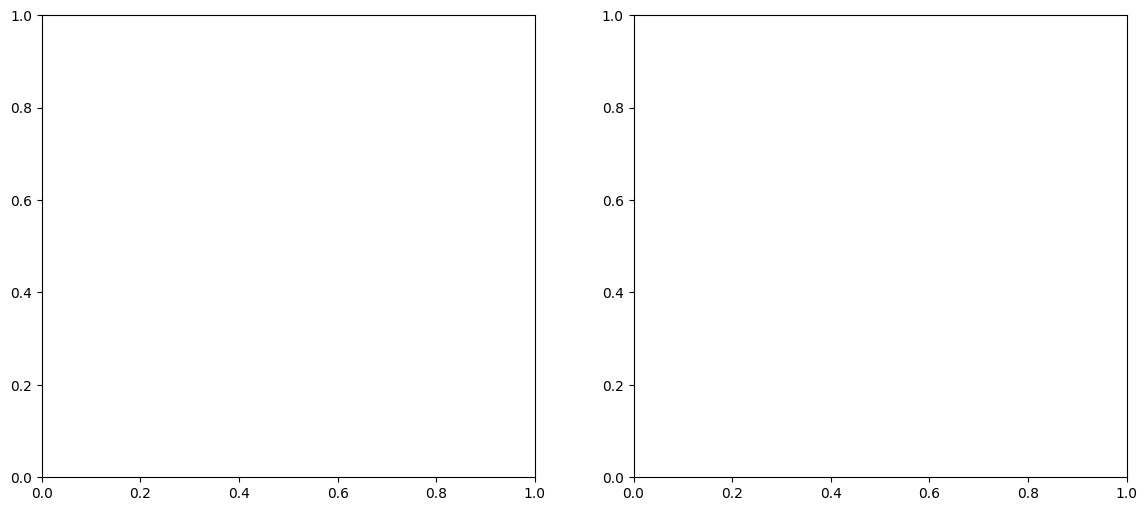

In [ ]:
# Visualizations
slice_idx = N_grid_1d // 2
slice_thickness = L * 0.05

# Using a smaller subset for the 3D/Scatter plotting is N_particles_1d is large:
if N_particles_1d > 64:
  subset_size = 5000
  print(f"Using a subset of {subset_size} particles for the scatter plots.")
else:
  subset_size = N_particles_1d**3
  print(f"Using all {subset_size} particles for the scatter plots.")
subset_indices = np.random.choice(N_particles_1d**3, subset_size, replace=False)

# Final Particle Distributions.
print("n\-- Plotting Final Particle Distribution --")

fig_3d = plt.figure(figsize=(7, 7))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(final_position_a[subset_indices, 0],
              final_position_a[subset_indices, 1],
              final_position_a[subset_indices, 2],
              s=1, alpha=0.2) # Small, semi-transparent points
ax_3d.set_title(f"Final Particle Positions (Subset) (a={a_final:.2f})")
ax_3d.set_xlabel("x [Mpc/h]")
ax_3d.set_ylabel("y [Mpc/h]")
ax_3d.set_zlabel("z [Mpc/h]")
ax_3d.set_xlim(0, L)
ax_3d.set_ylim(0, L)
ax_3d.set_zlim(0, L)
plt.show()


# 1b. 2D Slice Projection
fig_slice, ax_slice = plt.subplots(figsize=(7, 7))
slice_axis = 2 # Project along z
pos_axes = [0, 1] # Plot x vs y
slice_center = L / 2.0
select_slice = np.abs(final_position_a[:, slice_axis] - slice_center) < (slice_thickness / 2.0)

# Plot only a subset if the slice contains too many points
particles_in_slice = np.sum(select_slice)
print(f"{particles_in_slice} particles in the 2D slice.")
if particles_in_slice > 20000: # Limit plotted points for performance
    print(f"Plotting a random subset of 20000 particles from the slice.")
    slice_indices = np.where(select_slice)[0]
    plot_indices = np.random.choice(slice_indices, 20000, replace=False)
else:
    plot_indices = select_slice # Plot all particles in the slice

ax_slice.scatter(final_position_a[plot_indices, pos_axes[0]],
                 final_position_a[plot_indices, pos_axes[1]],
                 s=0.1, alpha=0.5, c='black')
ax_slice.set_title(f"Final Particle Slice (a={a_final:.2f}, Depth={slice_thickness:.1f} Mpc/h)")
ax_slice.set_xlabel(f"Axis {pos_axes[0]} [Mpc/h]")
ax_slice.set_ylabel(f"Axis {pos_axes[1]} [Mpc/h]")
ax_slice.set_xlim(0, L)
ax_slice.set_ylim(0, L)
ax_slice.set_aspect('equal', adjustable='box')
plt.show()


# --- 2. Final Density Contrast ---

print("\n--- Plotting Final Density Contrast ---")

# Calculate final density contrast using the correct function
delta_final = cic_density(final_position_a, N_grid_1d, L)

# Plot comparison: Initial vs Final density slice
fig_dens, axes_dens = plt.subplots(1, 2, figsize=(14, 6))

# Initial Density Field Slice (Linear Scale)
norm_initial = colors.Normalize(vmin=np.percentile(initial_density_field, 0.5),
                                vmax=np.percentile(initial_density_field, 99.5))
im0 = axes_dens[0].imshow(initial_density_field[:, :, slice_idx].T, # Check transpose if needed
                         origin='lower', extent=[0, L, 0, L],
                         cmap='viridis', norm=norm_initial, aspect='equal')
axes_dens[0].set_title(f'Initial Density Slice δ(x) (a={a_initial:.2f})')
axes_dens[0].set_xlabel('x [Mpc/h]')
axes_dens[0].set_ylabel('y [Mpc/h]')
plt.colorbar(im0, ax=axes_dens[0], label='Initial δ', shrink=0.8)

# Final Density Contrast Slice (Log Scale for 1+delta)
vmin_log = 0.1 # Min for 1+delta log scale
vmax_log = max(1.1, np.percentile(1 + delta_final, 99.8)) # Clip high peaks
norm_final = colors.LogNorm(vmin=vmin_log, vmax=vmax_log)
im1 = axes_dens[1].imshow(1 + delta_final[:, :, slice_idx].T, # Check transpose
                         origin='lower', extent=[0, L, 0, L],
                         cmap='viridis', norm=norm_final, aspect='equal')
axes_dens[1].set_title(f'Final Density Slice (1+δ) (a={a_final:.2f})')
axes_dens[1].set_xlabel('x [Mpc/h]')
# axes_dens[1].set_ylabel('y [Mpc/h]') # Shared y-axis
plt.colorbar(im1, ax=axes_dens[1], label='Final 1 + δ (Log Scale)', shrink=0.8)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.4e}")
print(f"Standard deviation of final δ:   {np.std(delta_final):.4e}")
print(f"Min/Max of initial δ: {np.min(initial_density_field):.4e} / {np.max(initial_density_field):.4e}")
print(f"Min/Max of final δ:   {np.min(delta_final):.4e} / {np.max(delta_final):.4e}")


# --- 3. Final Velocity Field (Quiver Plot in Slice) ---

print("\n--- Plotting Final Velocity Field (Slice) ---")

# Interpolate velocities to grid points for quiver plot visualization
# (Note: This averages velocities in cells, CIC is usually for density/force)
# A simpler approach is to plot velocity arrows AT particle positions (subset)

fig_vel, ax_vel = plt.subplots(figsize=(8, 8))

# Select a subset of particles within the 2D slice for velocity arrows
# Use the same 'select_slice' and potentially 'plot_indices' as the particle slice plot
# Reduce the number further for quiver clarity if needed
if particles_in_slice > 5000:
     quiver_indices = np.random.choice(np.where(select_slice)[0], 5000, replace=False)
elif particles_in_slice > 0 :
     quiver_indices = select_slice
else:
     quiver_indices = []
     print("No particles in slice for quiver plot.")


if len(quiver_indices) > 0:
    # Extract positions and velocities for the selected particles
    pos_q = final_position_a[quiver_indices]
    vel_q = final_velocity_a[quiver_indices] # Units: km/s

    # Plot arrows (velocities) at particle positions
    # Normalize arrows for better visualization or use magnitude for color
    vel_mag_q = np.sqrt(np.sum(vel_q[:, pos_axes]**2, axis=1)) # Magnitude in the plotted plane
    max_vel_mag = np.percentile(vel_mag_q, 99) # Avoid extreme arrows dominating scale
    norm_vel = colors.Normalize(vmin=0, vmax=max_vel_mag)

    # scale_factor = L / max_vel_mag / 10 # Adjust scale for reasonable arrow lengths
    scale_factor = 5e2 # Experiment with this scale value
    ax_vel.quiver(pos_q[:, pos_axes[0]], pos_q[:, pos_axes[1]],
                  vel_q[:, pos_axes[0]], vel_q[:, pos_axes[1]],
                  color='red', # Or use vel_mag_q with cmap
                  scale=scale_factor, # Adjust scale
                  scale_units='width', # Or 'xy' etc.
                  alpha=0.6, width=0.003)

ax_vel.set_title(f"Final Velocity Field Slice (a={a_final:.2f})")
ax_vel.set_xlabel(f"Axis {pos_axes[0]} [Mpc/h]")
ax_vel.set_ylabel(f"Axis {pos_axes[1]} [Mpc/h]")
ax_vel.set_xlim(0, L)
ax_vel.set_ylim(0, L)
ax_vel.set_aspect('equal', adjustable='box')
# Optional: Add background density
# ax_vel.imshow(1 + delta_final[:, :, slice_idx].T, origin='lower', extent=[0, L, 0, L],
#              cmap='viridis', norm=norm_final, aspect='equal', alpha=0.3, zorder=-1)
plt.show()


# --- 4. Final Comoving Acceleration Field (Slice) ---

print("\n--- Plotting Final Comoving Acceleration Field ---")

# final_g_comov_grid units: (km/s)^2 * a^2 / (h * Mpc) with a = a_final
g_comov_x_slice = final_g_comov_grid[0, :, :, slice_idx].T # Transpose for imshow
g_comov_y_slice = final_g_comov_grid[1, :, :, slice_idx].T

# Determine appropriate color limits (use diverging map)
g_abs_max = np.percentile(np.abs(final_g_comov_grid[0]), 99.5) # Use x-component for scale
norm_g = colors.Normalize(vmin=-g_abs_max, vmax=g_abs_max)

fig_g, ax_g = plt.subplots(figsize=(8, 6))
im_g = ax_g.imshow(g_comov_x_slice,
                  origin='lower', extent=[0, L, 0, L],
                  cmap='RdBu_r', # Red = positive accel (away?), Blue = negative (towards?)
                  norm=norm_g, aspect='equal')
ax_g.set_title(f"Comoving Acceleration Slice (g_c,x) at a={a_final:.2f}")
ax_g.set_xlabel("x [Mpc/h]")
ax_g.set_ylabel("y [Mpc/h]")
# Units at a=a_final
unit_label = f"(km/s)^2 * ({a_final:.2f})^2 / (h Mpc)"
plt.colorbar(im_g, label=f"g_c,x [{unit_label}]", shrink=0.8)
plt.show()

# Optional: Plot magnitude
# g_comov_mag_slice = np.sqrt(g_comov_x_slice**2 + g_comov_y_slice**2)
# ... (imshow g_comov_mag_slice with a sequential colormap like 'viridis' or 'plasma')

NameError: name 'pos_history_euler' is not defined

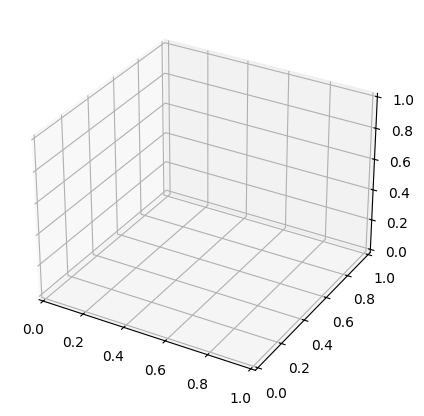

In [ ]:
# Visualizations for Euler's Integration:
subset = np.random.choice(len(positions), 1000, replace=False)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pos_history_euler[0][subset, 0], pos_history_euler[0][subset, 1],
           pos_history_euler[0][subset, 2], s=5, alpha=0.5)
ax1.set_title("Initial Particle Positions (z=99)")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_position_euler[subset, 0], final_position_euler[subset, 1],
           final_position_euler[subset, 2], s=5, alpha=0.5)
ax2.set_title("Final Particle Positions (after 100 Myr)")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined from your simulation:
# - positions_history: list of particle positions at each timestep, with positions_history[-1] being the final positions
# - N: grid size (e.g., 128 for a 128^3 grid)
# - L: physical box size in Mpc/h
# - a_current: final scale factor after the leapfrog integration
# - cic_interpolation: function that computes the density grid from particle positions

# Step 1: Compute the density grid using CIC interpolation from the final particle positions.
density_final = cic_initial(final_position_euler, N_grid_cells, L)

# Step 2: Calculate the mean density
# Total mass is distributed over N^3 grid cells; mean density is total mass / number of cells
mean_density_final = np.sum(density_final) / (N_grid_cells**3)

# Step 3: Compute the density contrast δ(x) = (ρ(x) / ρ_mean) - 1
delta_final = (density_final / mean_density_final) - 1

# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_final[N_grid_cells//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N_grid_cells//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_final):.3e}")